# Прогнозирование рейтинга отелей

> Для корректной работы ссылок оглавления лучше смотреть проект здесь \
> https://nbviewer.org/github/experiment0/sf_data_science/blob/main/project_04/hotel_rating_prediction.ipynb

В данном проекте приводится решение задачи соревнования https://www.kaggle.com/competitions/sf-booking/submissions

# Оглавление
- [1. Описание задачи](#item_1)
- [2. Загрузка библиотек и данных, удаление дубликатов](#item_2)
- [3. Описание столбцов](#item_3)
- [4. Преобразование данных](#item_4)
    - [4.1. Удалим пробелы в начале и конце у признаков с типом object](#item_4_1)
	- [4.2. Переведем признак days_since_review в числовой](#item_4_2)
	- [4.3. Переведем review_date в формат даты](#item_4_3)
    - [4.4. Переведем тексты отзывов на английский](#item_4_4)
    - [4.5. Заполним значения NaN в столбце reviewer_nationality](#item_4_5)
- [5. Проверка данных на наличие выбросов](#item_5)
- [6. Заполнение пропусков в столбцах lat и lng](#item_6)
- [7. Предварительное исследование данных](#item_7)
- [8. Создание и преобразование признаков](#item_8)
    - [8.1. Создание признаков из столбца hotel_address](#item_8_1)
	    - Создание признака hotel_country
		- Создание признака hotel_city
		- Создание признака postal_code
    - [8.2. Уточнение признака hotel_name](#item_8_2)
    - [8.3. Создание признаков по текстовым отзывам](#item_8_3)        
        - Создание признаков с общим количеством положительных и отрицательных отзывов об отелях (total_positive_reviews и total_negative_reviews)
        - Создание численных оценок отызвов с помощью библиотеки nltk
	- [8.4. Создание признака review_from_resident](#item_8_4)
	- [8.5. Создание признака distance_from_city_center](#item_8_5)
    - [8.6. Создание признаков из столбца tags](#item_8_6)
        - Создание признака trip_type
        - Создание признака review_from_mobile
        - Создание признака visitor_type
        - Создание признака nights_count
        - Создание признака room_level
        - Создание признака is_big_bed
        - Создание признака is_room_with_view
        - Создание признака tags_count    
    - [8.7. Создание признаков из столбца review_date](#item_8_7)
        - Создание признака review_month
        - Создание признака review_season
        - Создание признака review_day
        - Создание признака review_month_day
- [9. Оценка влияния признаков на целевую переменную и удаление не актуальных признаков](#item_9)
- [10. Кодирование признаков](#item_10)
- [11. Нормализация признаков](#item_11)
- [12. Построение модели](#item_12)
    - [12.1. Создание модели для проверки значения MAPE](#item_12_1)
    - [12.2. Обучение модели на всех данных и получение предсказания](#item_12_2)

> **Примечание**.\
>Перевод текстов отзывов на английский занимает довольно много времени (около двух часов).\
>Поэтому результат, полученный в пункте **4.4.**, был записан в таблицу `data_hotels_lang.csv`,\
>а выполнение ячеек с кодом перевода остановлено с помощью `%%script echo skipping`.\
>И после пункта **4.4.** мы продолжаем работу с полученной и записанной таблицей `data_hotels_lang.csv`.\
>При желании код с переводом можно выполнить и получить тот же результат.\
>Все используемые и полученные таблицы можно скачать здесь https://disk.yandex.ru/d/ZtKWh0Kxd5XsvA .

# 1. Описание задачи <a id="item_1"></a>

Нужно решить предполагаемую задачу для компании Booking, которая занимается предоставлением услуг бронирования отелей.\
Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.\
Нужно создать модель, которая будет предсказывать рейтинг отеля.

# 2. Загрузка библиотек и данных, удаление дубликатов <a id="item_2"></a>

Загрузим необходимые библиотеки.

In [1]:
import ast
import datetime
import pandas as pd
import numpy as np
import datetime
from collections import Counter

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# библиотека для перевода текста на английский
import googletrans
from googletrans import Translator

import langid

# библиотека для оценки тональности текста
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# библиотека для работы с широтой и долготой
from geopy.distance import geodesic as GD

# библиотека для кодирования признаков
import category_encoders as ce

# инструменты для оценки точности модели
from sklearn import metrics
# инструмент для нормализации, стандартизации данных
from sklearn import preprocessing

# инструмент для разделения датасета
from sklearn.model_selection import train_test_split

# методы для оценки значимости признаков
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# инструмент для создания и обучения модели 
from sklearn.ensemble import RandomForestRegressor

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\exper\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Определим константы для дальнейшего использования.

In [2]:
# фиксируем для воспроизводимости экспериментов.
RANDOM_SEED = 42

# путь к каталогу с данными для соревнования
DATA_DIR = './data/'

np.random.seed(RANDOM_SEED)

Загрузим данные из таблиц для соревнования.

In [3]:
# датасет для обучения
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv')

# датасет для предсказания
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')

# пример сабмишина
sample_submission = pd.read_csv(DATA_DIR+'submission.csv')

In [4]:
print(df_train.shape, df_test.shape, sample_submission.shape)

(386803, 17) (128935, 16) (128935, 2)


Посмотрим на датасет для обучения.

In [5]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Посмотрим на датасет для предсказания.

In [7]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Посмотрим на пример сабмишина.

In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


Проверим **df_train** на дубликаты.

In [11]:
dupl_columns = list(df_train.columns)

mask = df_train.duplicated(subset=dupl_columns)
train_duplicates = df_train[mask]

print(f'Число найденных дубликатов: {train_duplicates.shape[0]}')

Число найденных дубликатов: 307


Удалим дубликаты из **df_train**.

In [12]:
df_train = df_train.drop_duplicates(subset=dupl_columns)

print(f'Результирующее число записей: {df_train.shape[0]}')

Результирующее число записей: 386496


Для корректной обработки признаков объединим датасеты для обучения и предсказания.

In [13]:
# помечаем где у нас трейн
df_train['is_train_data'] = 1

# помечаем где у нас тест
df_test['is_train_data'] = 0

# в тесте у нас нет значения reviewer_score, мы его должны предсказать, 
# поэтому пока просто заполняем нулями
df_test['reviewer_score'] = 0 

# объединяем таблицы
data_hotels = pd.concat([df_train, df_test], ignore_index=True)

Для дальнейшей работы нам понадобиться рассматривать только тренировочные или тестовые данные и убирать колонку **is_train_data**.\
Напишем для этого функции.

In [14]:
# возвращает только тренировочные данные без колонки is_train_data
def get_train_data(data):
    train_mask = data['is_train_data'] == 1
    return data[train_mask].drop(['is_train_data'], axis=1)


# возвращает только данные для теста без колонок is_train_data и reviewer_score
def get_test_data(data):
    test_mask = data['is_train_data'] == 0
    return data[test_mask].drop(['is_train_data', 'reviewer_score'], axis=1)

Посмотрим на результат объединения.

In [15]:
data_hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,is_train_data
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


In [16]:
data_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

В колонках **lat** и **lng** есть пропуски. Позднее заполним их.

# 3. Описание столбцов <a id="item_3"></a>

In [17]:
# Создадим словарь описания столбцов, чтобы в дальнейшем получать нужные данные
columns = {
    'hotel_address': 'адрес отеля',
    'additional_number_of_scoring': 'есть также некоторые гости, которые просто поставили оценку сервису, \
но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.',
    'review_date': 'дата, когда рецензент разместил соответствующий отзыв',
    'average_score': 'средний балл отеля, рассчитанный на основе последнего комментария за последний год',
    'hotel_name': 'название отеля',
    'reviewer_nationality': 'страна рецензента',
    'negative_review': 'отрицательный отзыв, который рецензент дал отелю',
    'review_total_negative_word_counts': 'общее количество слов в отрицательном отзыв',
    'total_number_of_reviews': 'общее количество действительных отзывов об отеле',
    'positive_review': 'положительный отзыв, который рецензент дал отелю',
    'review_total_positive_word_counts': 'общее количество слов в положительном отзыве',
    'total_number_of_reviews_reviewer_has_given': 'количество отзывов, которые рецензенты дали в прошлом',
    'reviewer_score': 'оценка, которую рецензент поставил отелю на основе своего опыта',
    'tags': 'теги, которые рецензент дал отелю',
    'days_since_review': 'количество дней между датой проверки и датой очистки',
    'lat': 'географическая широта отеля',
    'lng': 'географическая долгота отеля',
    'is_train_data': 'флаг, что строка из датасета для обучения',
}

In [18]:
def print_column_descriptions(df, columns_list = []):
    """Выводит описания столбцов
    Args:
        df (DataFrame): дата-фрейм, для столбцов которого выводим информацию
        columns_list (list): список столбцов для вывода        
    """
    # если список столбцов не передан, выведем данные о всех столбцах
    if (len(columns_list) == 0):
        columns_list = list(df.columns)
    
    # заголовок колонки с признаком
    key_title = 'Признак'
    
    # количество символов в самом длинном значении в левой колонке
    max_key_len = len(max(columns_list + [key_title], key=len))
    # количество символов в самом длинном названии типа (datetime64[ns])
    max_type_len = 14
    
    # печатаем "шапку" вывода
    print(key_title.ljust(max_key_len, '.'), ':', 'Тип'.ljust(max_type_len, '.'), ':', 'Описание')
    print()
    
    # печатаем список с описаниями
    for column_name in columns_list:
        print(
            column_name.ljust(max_key_len, '.'), ':', 
            str(df.dtypes[column_name]).ljust(max_type_len, '.'), ':', 
            columns[column_name]
        )


def delete_from_columns(column_keys):
    """Удаляет значения из словаря с описанием столбцов
    Args:
        column_keys (list): список столбцов для удаления
    """
    for column_name in column_keys:
        if (column_name in columns):
            del columns[column_name]

**Исходный датафрейм содержит следующие столбцы:**

In [19]:
print_column_descriptions(data_hotels)

Признак................................... : Тип........... : Описание

hotel_address............................. : object........ : адрес отеля
additional_number_of_scoring.............. : int64......... : есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
review_date............................... : object........ : дата, когда рецензент разместил соответствующий отзыв
average_score............................. : float64....... : средний балл отеля, рассчитанный на основе последнего комментария за последний год
hotel_name................................ : object........ : название отеля
reviewer_nationality...................... : object........ : страна рецензента
negative_review........................... : object........ : отрицательный отзыв, который рецензент дал отелю
review_total_negative_word_counts......... : int64......... : общее количество слов в отрицательном отз

Необходимо сделать предсказание для признака **reviewer_score**.

# 4. Преобразование данных <a id="item_4"></a>

## 4.1. Удалим пробелы в начале и конце у признаков с типом object <a id="item_4_1"></a>

In [20]:
# Выделим столбцы с типом object
object_columns = data_hotels.select_dtypes(include=[object]).columns.tolist()

# Удалим пробелы в начале и конце строк
for column_name in object_columns:
    data_hotels[column_name] = data_hotels[column_name].apply(lambda x: x.strip())

## 4.2. Переведем признак days_since_review в числовой <a id="item_4_2"></a>

In [21]:
print_column_descriptions(data_hotels, ['days_since_review'])

Признак.......... : Тип........... : Описание

days_since_review : object........ : количество дней между датой проверки и датой очистки


In [22]:
# Посмотрим, что в нем содержится
data_hotels['days_since_review'].head(3)

0    531 day
1    203 day
2    289 day
Name: days_since_review, dtype: object

In [23]:
def get_count_of_days(days_since_review):
    """Формат записи в столбце days_since_review имеет вид: "N day", где N - число.
    Функция возвращает число N.
    Args:
        days_since_review (str): первоначальное значение из столбца
    Returns:
        int: количество дней
    """
    words = days_since_review.split()
    return int(words[0])

data_hotels['days_since_review'] = data_hotels['days_since_review'].apply(get_count_of_days)

In [24]:
# Посмотрим на результат
data_hotels['days_since_review'].head(3)

0    531
1    203
2    289
Name: days_since_review, dtype: int64

## 4.3. Переведем review_date в формат даты <a id="item_4_3"></a>

In [25]:
print_column_descriptions(data_hotels, ['review_date'])

Признак.... : Тип........... : Описание

review_date : object........ : дата, когда рецензент разместил соответствующий отзыв


In [26]:
# Посмотрим, что в нем содержится
data_hotels['review_date'].head(3)

0     2/19/2016
1     1/12/2017
2    10/18/2016
Name: review_date, dtype: object

In [27]:
data_hotels['review_date'] = pd.to_datetime(data_hotels['review_date'])

In [28]:
# Посмотрим на результат
data_hotels['review_date'].head(3)

0   2016-02-19
1   2017-01-12
2   2016-10-18
Name: review_date, dtype: datetime64[ns]

## 4.4. Переведем тексты отзывов на английский <a id="item_4_4"></a>

Если отзывов нет, то на месте позитивного отзыва идет текст "No positive", а на месте негативного "No negative".\
Оставим просто пустые строки, если нет отзывов.\
Для дальнейшей работы это будет удобнее.

In [29]:
def get_review_text(review_text, word_counts):
    """Вернет либо сам отзыв, либо пустую строку, если его нет.
    Args:
        review_text (str): текст отзыва
        word_counts (int): количество слов в отзыве
    Returns:
        str: обновленное значение для текста отзыва.
    """
    if (word_counts == 0):
        return ''
    return review_text

data_hotels['positive_review'] = \
    data_hotels.apply(lambda x: get_review_text(x['positive_review'], x['review_total_positive_word_counts']), axis=1)
    
data_hotels['negative_review'] = \
    data_hotels.apply(lambda x: get_review_text(x['negative_review'], x['review_total_negative_word_counts']), axis=1)

Тексты некоторых отзывов написаны не на английском.\
Переведем их на английский, чтобы библиотека **nltk** смогла посчитать значения тональности отзывов.

Создадим признаки **positive_review_language** и **negative_review_language** - \
исходные языки положительного и отрицательного отзывов.

In [261]:
%%script echo skipping

# Этот код выполнялся около 40 минут.
# Ниже его результат записан в таблицу data_hotels_lang.csv.
# И дальше будем использовать полученные данные из нее, чтобы не ждать каждый раз.

# Возвращает язык переданного текста
def get_review_language(review_text): 
    return langid.classify(review_text)[0]

# язык позитивного отзыва
data_hotels['positive_review_language'] = data_hotels['positive_review'].apply(get_review_language)
# язык негативного отзыва
data_hotels['negative_review_language'] = data_hotels['negative_review'].apply(get_review_language)

Couldn't find program: 'echo'


Теперь переведем отзывы на английский.

In [262]:
%%script echo skipping

# Этот код выполнялся около 50 минут.
# Ниже его результат записан в таблицу data_hotels_lang.csv.
# И дальше будем использовать полученные данные из нее, чтобы не ждать каждый раз.

translator = Translator()

def get_translate_review(review_text, lang):
    if (lang == 'en'):
        return review_text
    
    result = translator.translate(review_text)
    
    # У гугл-переводчика может быть свое мнение о том, на каком языке написан текст.
    # Изначально вместо него использован langid, потому что работает быстрее.
    if (result.src == 'en'):
        return review_text
    
    return result.text


data_hotels['positive_review'] = \
    data_hotels.apply(lambda x: get_translate_review(x['positive_review'], x['positive_review_language']), axis=1)

Couldn't find program: 'echo'


In [263]:
%%script echo skipping

# Этот код выполнялся около 25 минут.
# Ниже его результат записан в таблицу data_hotels_lang.csv.
# И дальше будем использовать полученные данные из нее, чтобы не ждать каждый раз.

data_hotels['negative_review'] = \
    data_hotels.apply(lambda x: get_translate_review(x['negative_review'], x['negative_review_language']), axis=1)

Couldn't find program: 'echo'


In [264]:
%%script echo skipping

# Запомним результат в таблицу
data_hotels.to_csv(DATA_DIR+'data_hotels_lang.csv', index=False)

Couldn't find program: 'echo'


In [30]:
# Получим таблицу с записанным выше результатом, и дальше будем работать с ней
data_hotels = pd.read_csv(DATA_DIR+'data_hotels_lang.csv')
# Повторно переведем признак review_date в формат даты
data_hotels['review_date'] = pd.to_datetime(data_hotels['review_date'])

data_hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,is_train_data,positive_review_language,negative_review_language
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,51.507894,-0.143671,1,en,en
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203,51.521009,-0.123097,1,en,nl


In [31]:
# Добавим описания столбцов в список
columns.update({'positive_review_language': 'язык позитивного отзыва'})
columns.update({'negative_review_language': 'язык негативного отзыва'})

In [32]:
# Проверим, что после скачивания таблицы в столбцах правильный тип данных
print_column_descriptions(data_hotels)

Признак................................... : Тип........... : Описание

hotel_address............................. : object........ : адрес отеля
additional_number_of_scoring.............. : int64......... : есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
review_date............................... : datetime64[ns] : дата, когда рецензент разместил соответствующий отзыв
average_score............................. : float64....... : средний балл отеля, рассчитанный на основе последнего комментария за последний год
hotel_name................................ : object........ : название отеля
reviewer_nationality...................... : object........ : страна рецензента
negative_review........................... : object........ : отрицательный отзыв, который рецензент дал отелю
review_total_negative_word_counts......... : int64......... : общее количество слов в отрицательном отз

## 4.5. Заполним значения NaN в столбце reviewer_nationality <a id="item_4_5"></a>

В столбце **reviewer_nationality** есть пропущенные значения.

In [33]:
reviewer_nationality_mask_nan = data_hotels['reviewer_nationality'].isnull()
data_hotels[reviewer_nationality_mask_nan]['reviewer_nationality']

189       NaN
457       NaN
746       NaN
1483      NaN
4223      NaN
         ... 
509284    NaN
511446    NaN
512967    NaN
513024    NaN
515073    NaN
Name: reviewer_nationality, Length: 523, dtype: object

Заполним их значением **Unknown**

In [34]:
data_hotels['reviewer_nationality'] = data_hotels['reviewer_nationality'].fillna('Unknown')

Проверим, что пропуски заполнились.

In [35]:
data_hotels['reviewer_nationality'].isnull().sum()

0

# 5. Проверка данных на наличие выбросов <a id="item_5"></a>

Посмотрим на распределение числовых признаков.

In [36]:
def show_boxplot(data, column_name, title, xlabel):
    """Отображает график коробчатой диаграммы
    Args:
        data (DataFrame): дата-фрейм, для которого будем строить график
        column_name (str): имя столбца, по данным которого будем строить график
        title (str): название графика
        xlabel (str): подпись по оси Х
    """
    fig = plt.figure(figsize=(10, 4))
    axes = fig.add_axes([0, 0, 1, 1])
    axes.set_title(title)
    axes.grid()

    boxplot = sns.boxplot(
        data=data,
        x=column_name,
        orient='h',
    )

    boxplot.set_xlabel(xlabel)


# для исследования возьмем тренировочные данные, так как из тестовых данных удалять все равно ничего не будем
research_data = get_train_data(data_hotels)

# возьмем столбцы с числовыми данными
number_columns = research_data.select_dtypes(include=np.number).columns.tolist()

# выведем их описание
print_column_descriptions(research_data, number_columns)

Признак................................... : Тип........... : Описание

additional_number_of_scoring.............. : int64......... : есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
average_score............................. : float64....... : средний балл отеля, рассчитанный на основе последнего комментария за последний год
review_total_negative_word_counts......... : int64......... : общее количество слов в отрицательном отзыв
total_number_of_reviews................... : int64......... : общее количество действительных отзывов об отеле
review_total_positive_word_counts......... : int64......... : общее количество слов в положительном отзыве
total_number_of_reviews_reviewer_has_given : int64......... : количество отзывов, которые рецензенты дали в прошлом
reviewer_score............................ : float64....... : оценка, которую рецензент поставил отелю на основе своего о

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>,
        <AxesSubplot:title={'center':'days_since_review'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'lng'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

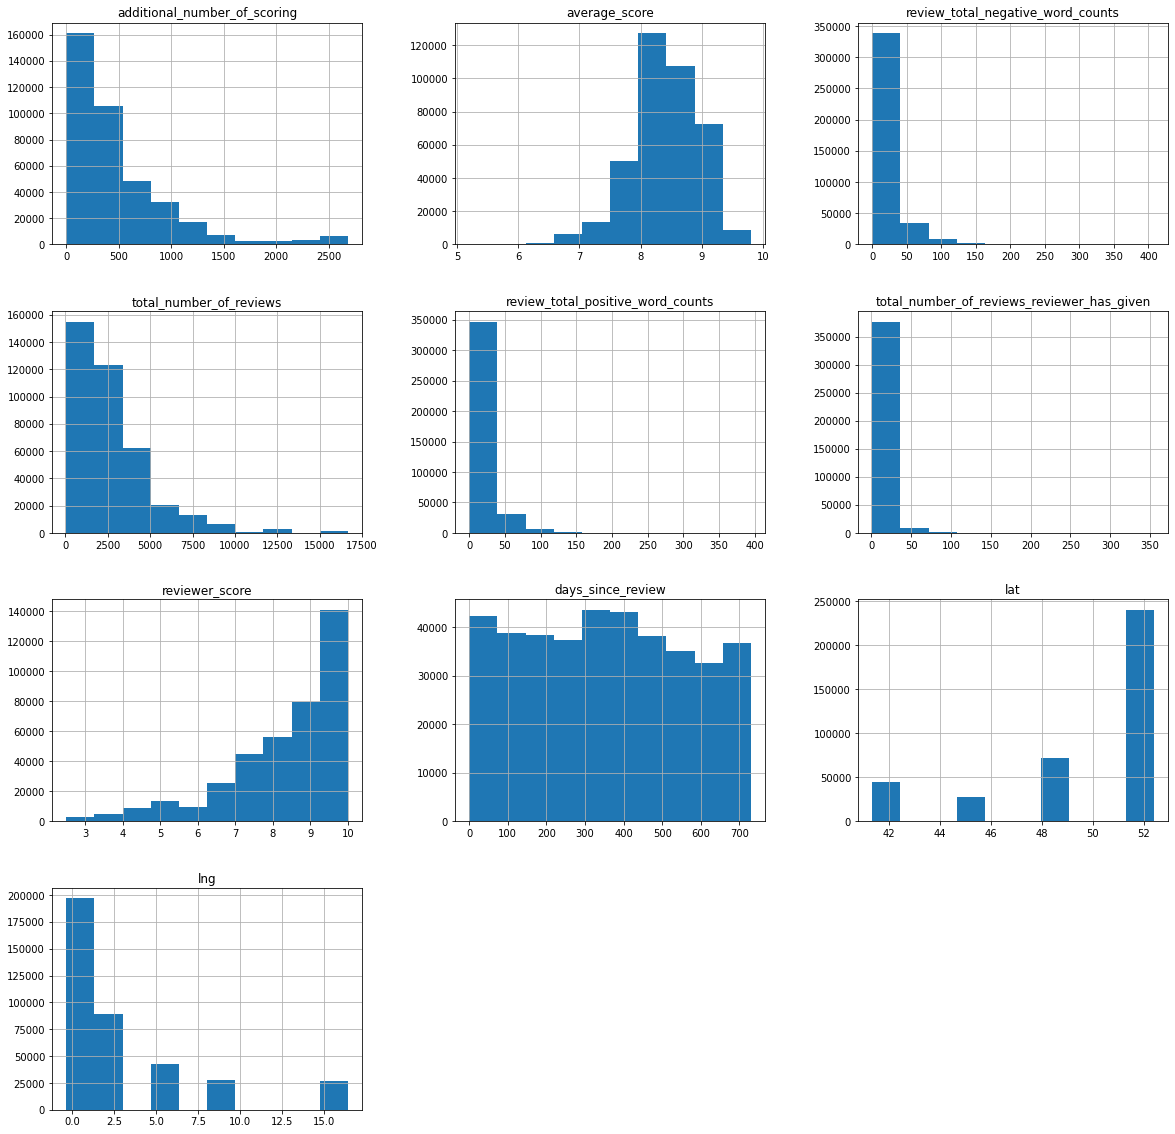

In [37]:
# построим гистаграммы числовых признаков
research_data[number_columns].hist(figsize=(20,20))

In [38]:
# посмотрим характеристики распределения числовых признаков
research_data[number_columns].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng
count,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,384048.000000,384048.000000
mean,498.504375,8.397421,18.539400,2744.679231,17.778163,7.176211,8.397299,354.339339,49.443988,2.823740
std,500.365093,0.547861,29.703569,2316.934876,21.724766,11.052453,1.635747,208.958145,3.468266,4.580782
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,0.000000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,175.000000,48.214277,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,353.000000,51.500198,-0.000250
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,527.000000,51.516384,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,730.000000,52.400181,16.429233


Посмотрим на распределение признаков **review_total_negative_word_counts** и **review_total_positive_word_counts**.

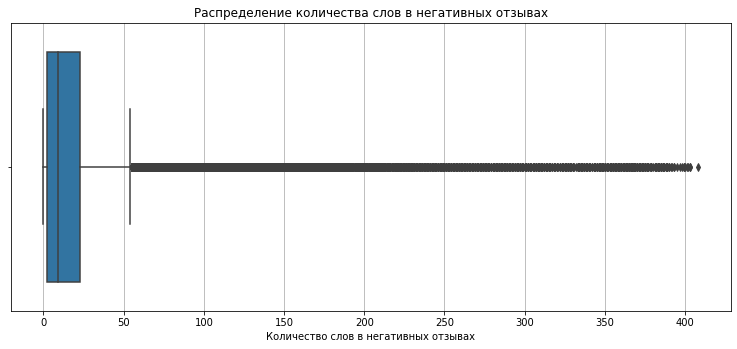

In [39]:
show_boxplot(
        research_data, 
        'review_total_negative_word_counts', 
        'Распределение количества слов в негативных отзывах', 
        'Количество слов в негативных отзывах'
    )

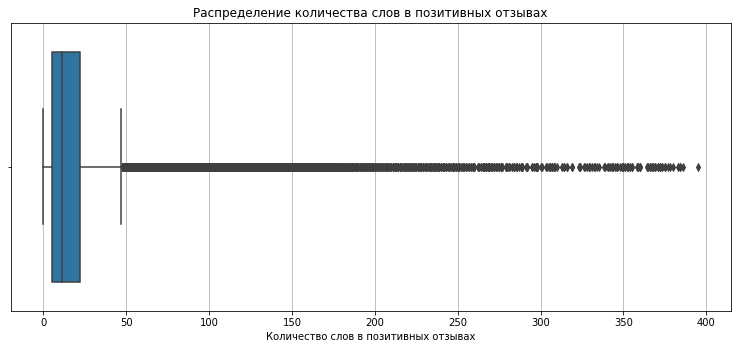

In [40]:
show_boxplot(
        research_data, 
        'review_total_positive_word_counts', 
        'Распределение количества слов в позитивных отзывах', 
        'Количество слов в позитивных отзывах'
    )

Выбросы не единичные, их довольно много.\
Поэтому не будем удалять строки с большим количеством слов в отзывах.

Распределение числовых признаков не является нормальным.\
Единственное похожее на нормальное распределение есть у признака **average_score**.\
Но сами значения не выходят за рамки правдоподобных.\
Поэтому не будем ничего удалять.

# 6. Заполнение пропусков в столбцах lat и lng <a id="item_6"></a>

In [41]:
print_column_descriptions(data_hotels, ['lat', 'lng'])

Признак : Тип........... : Описание

lat.... : float64....... : географическая широта отеля
lng.... : float64....... : географическая долгота отеля


Посмотрим на адреса отелей, для которых есть данные пропуски.

In [42]:
mask_lat_nan = data_hotels['lat'].isna()
mask_lng_nan = data_hotels['lng'].isna()

data_hotels_without_lat_or_lng = data_hotels[mask_lat_nan | mask_lng_nan]
print(f"Уникальных адресов с пропусками значений lat или lng: \
      {data_hotels_without_lat_or_lng['hotel_address'].nunique()}")

Уникальных адресов с пропусками значений lat или lng:       17


Выведем эти адреса.

In [43]:
data_hotels_without_lat_or_lng['hotel_address'].unique()

array(['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Sep lveda 180 Eixample 08011 Barcelona Spain',
       'Pau Clar s 122 Eixample 08009 Barcelona Spain',
       'Josefst dter Stra e 22 08 Jos

Найдем для них значения широты и долготы.\
(Библиотека **geopy** работает нестабильно, и для одного и того же адреса то находит данные, то нет.\
Поэтому в данном случае проще собрать данные вручную, потому что их немного.)

In [44]:
address_locations = {
    'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': (48.211783, 16.297308),
    '23 Rue Damr mont 18th arr 75018 Paris France': (48.856663, 2.351556),
    'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': (48.210918, 16.347119),
    'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': (48.222139, 16.357513),
    '4 rue de la P pini re 8th arr 75008 Paris France': (48.856663, 2.351556),
    'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': (48.245935, 16.341397),
    'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': (48.218213, 16.39411),
    'Bail n 4 6 Eixample 08010 Barcelona Spain': (41.396133, 1.655829),
    'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': (48.222139, 16.357513),
    'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': (48.206487, 16.36346),
    'Paragonstra e 1 11 Simmering 1110 Vienna Austria': (48.176599, 16.413999),
    'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': (48.222139, 16.357513),
    '20 Rue De La Ga t 14th arr 75014 Paris France': (48.838331, 2.330948),
    'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': (48.778035, 15.65565),
    'Sep lveda 180 Eixample 08011 Barcelona Spain': (41.425226, 2.181864),
    'Pau Clar s 122 Eixample 08009 Barcelona Spain': (41.504994, 2.245959),
    'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': (48.210918, 16.347119),
}

Заполним этими данными пропуски в таблице.

In [45]:
for address, location in address_locations.items():
    mask_address = data_hotels['hotel_address'] == address
    data_hotels.loc[mask_address, 'lat'] = location[0]
    data_hotels.loc[mask_address, 'lng'] = location[1]

Проверим, что пропуски заполнились.

In [46]:
data_hotels[['lat', 'lng']].isnull().sum()

lat    0
lng    0
dtype: int64

# 7. Предварительное исследование данных <a id="item_7"></a>

Напишем функцию, которая выводит содержимое ячеек полностью.

In [47]:
def print_full_rows_data(data):
    """Выводит полные тексты для каждой строки
    Args:
        data (DataFrame): дата-фрейм, из которого будем выводить данные
    """
    for i, row in data.iterrows():
        print('Номер строки:', i)
        for key, value in row.items():        
            print(key, ':', value)            
        print()

Посмотрим, с какими фактами связаны наименьшие и наибольшие значения **reviewer_score**.

In [48]:
# Для исследований возьмем только тренировочные данные
train_data_hotels = get_train_data(data_hotels)

Посмотрим каких и сколько оценок есть.

In [49]:
train_data_hotels['reviewer_score'].value_counts()

10.0    86749
9.6     53471
9.2     44020
8.8     34767
8.3     30881
7.5     26136
7.9     24881
7.1     18518
6.7     14098
6.3     11238
5.8      8953
5.4      7079
5.0      6268
4.6      4651
4.2      3822
3.8      3012
3.3      2058
2.5      1628
2.9      1207
9.5       523
9.0       483
8.0       388
8.5       379
7.0       292
6.5       274
6.0       184
5.5       161
4.5        97
4.0        66
3.5        61
9.4        47
8.1        28
3.0        25
6.9        23
5.6        13
4.4         9
3.1         6
Name: reviewer_score, dtype: int64

Посмотрим, какие отели получили оценку 2.5

In [50]:
# маска для оценки 2.5
reviewer_score_mask = train_data_hotels['reviewer_score'] == 2.5

# строки с оценкой 2.5
research_data = train_data_hotels[reviewer_score_mask]

# сколько раз каждый отель получил оценку 2.5
research_data['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf     72
Grand Royale London Hyde Park                  25
Hotel Da Vinci                                 19
Henry VIII                                     18
Holiday Inn London Kensington                  17
                                               ..
Paris Marriott Rive Gauche Hotel                1
Hotel Vilamar                                   1
Andaz Amsterdam Prinsengracht A Hyatt Hotel     1
NH Hesperia Barcelona Presidente                1
Acca Palace                                     1
Name: hotel_name, Length: 625, dtype: int64

Посмотрим, с чем связаны плохие оценки у отеля "Britannia International Hotel Canary Wharf".

In [51]:
# Маска по названию отеля
hotel_name_mask = train_data_hotels['hotel_name'] == 'Britannia International Hotel Canary Wharf'

# Строки с оценкой 2.5 для выбранного отеля
research_data = train_data_hotels[hotel_name_mask & reviewer_score_mask]

# Выведем полную информацию из строк (для экономии места выведем только 2 строки)
print_full_rows_data(research_data.head(2))

Номер строки: 1956
hotel_address : 163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom
additional_number_of_scoring : 2682
review_date : 2017-05-22 00:00:00
average_score : 7.1
hotel_name : Britannia International Hotel Canary Wharf
reviewer_nationality : Romania
negative_review : It was the worst experience he had at a hotel
review_total_negative_word_counts : 13
total_number_of_reviews : 9086
positive_review : nan
review_total_positive_word_counts : 0
total_number_of_reviews_reviewer_has_given : 5
reviewer_score : 2.5
tags : [' Leisure trip ', ' Couple ', ' Standard Double Room without Window ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
days_since_review : 73
lat : 51.5019097
lng : -0.0232208
positive_review_language : en
negative_review_language : ca

Номер строки: 4530
hotel_address : 163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom
additional_number_of_scoring : 2682
review_date : 2016-12-12 00:00:00
average_score : 7.1
hotel_nam

Здесь для экономии места выведены данные только 2-х строк.\
Если просмотреть их больше, можно заметить следующее.
- Описание причины плохой оценки как правило содержиться в тексте отзыва.
- Есть записи с плохой оценкой, в которых нет обоих отзывов (положительного и отрицательного)
- Есть записи с хорошим отзывом, но плохой оценкой.
- В некоторых записях в тексте хорошего отзыва продолжается текст плохого.
- В некоторых записях плохой отзыв содержится в колонке для хорошего, а колонка для плохого пустая.
- Есть очень краткие тексты отзывов, состоящие из одного-двух слов, по смыслу примерно таких:\
Хорошо: Ничего; Плохо: Все.
- В некоторых строках тексты хорошего и плохого отзыва полностью совпадают.

То есть, имеет место быть неточное заполнение данных в текстах отзывов.\
В дальнейшем попробуем определить, хороший или плохой по смыслу отзыв с помощью библиотеки nltk \
 и использовать значения, полученные с помощью нее.

Посмотрим, много ли строк, где нет обоих отзывов, но есть оценка.

Посмотрим это только для оценок меньше 5. Потому что отсутствие отзывов при оценке выше среднего это нормально.

In [52]:
# маска, что оба отзыва пустые
mask_not_exists_reviews =\
    (train_data_hotels['review_total_positive_word_counts'] == 0) & \
    (train_data_hotels['review_total_negative_word_counts'] == 0)

# маска, что оценка <= 5
reviewer_score_mask = train_data_hotels['reviewer_score'] <= 5

# строки без обоих отзывов с оценкой <= 5
research_data = train_data_hotels[mask_not_exists_reviews & reviewer_score_mask]

# оставим только столбцы, которые представляют интерес
research_data[['hotel_address', 'average_score', 'hotel_name', 'reviewer_nationality', 'reviewer_score']]

,hotel_address,average_score,hotel_name,reviewer_nationality,reviewer_score
8130,Vijzelstraat 4 Amsterdam City Center 1017 HK A...,7.0,NH Carlton Amsterdam,Greece,4.6
28054,Passeig de Gr cia 29 Eixample 08007 Barcelona ...,8.3,Eurostars Bcn Design,United Kingdom,4.2
33969,163 Marsh Wall Docklands Tower Hamlets London ...,7.1,Britannia International Hotel Canary Wharf,France,2.5
39255,8 bis Avenue de la Soeur Rosalie 13th arr 7501...,7.6,Mercure Paris Gobelins Place d Italie,Switzerland,3.3
109650,Am Stadtpark 1 03 Landstra e 1030 Vienna Austria,8.0,Hilton Vienna,United Arab Emirates,4.2
208714,Koninginneweg 34 36 Oud Zuid 1075 CZ Amsterdam...,7.5,Park Plaza Vondelpark Amsterdam,Lebanon,4.6
334604,Moll de Barcelona WTC Ciutat Vella 08039 Barce...,8.5,Eurostars Grand Marina Hotel GL,Poland,3.3


Таких записей не так много, и чего-то общего у них не наблюдается. \
Оставим их для общей статистики отзывов.

Теперь посмотрим записи для лучших отелей.

In [53]:
# маска с оценкой 10
reviewer_score_mask = train_data_hotels['reviewer_score'] == 10

# строки с оценкой 10
research_data = train_data_hotels[reviewer_score_mask]

# посмотрим, какой отель сколько раз получил высшую оценку
research_data['hotel_name'].value_counts()

Intercontinental London The O2                       892
Park Plaza Westminster Bridge London                 822
M by Montcalm Shoreditch London Tech City            592
DoubleTree by Hilton Hotel London Tower of London    589
Hotel Esther a                                       572
                                                    ... 
AC Hotel Irla a Marriott Lifestyle Hotel               1
Hotel La Spezia Gruppo MiniHotel                       1
Holiday Inn Paris Montparnasse Pasteur                 1
Hotel Daniel Paris                                     1
Mercure Paris Champs Elys es                           1
Name: hotel_name, Length: 1481, dtype: int64

Посмотрим на записи с отелем "Intercontinental London The O2"

In [54]:
# маска по названию отеля
hotel_name_mask = train_data_hotels['hotel_name'] == 'Britannia International Hotel Canary Wharf'

# строки с оценкой 10 для выбранного отеля
research_data = train_data_hotels[hotel_name_mask & reviewer_score_mask]

# выведем полную информацию из строк (для экономии места выведем данные только из 2-х строк)
print_full_rows_data(research_data.head(2))

Номер строки: 340
hotel_address : 163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom
additional_number_of_scoring : 2682
review_date : 2016-12-22 00:00:00
average_score : 7.1
hotel_name : Britannia International Hotel Canary Wharf
reviewer_nationality : United Kingdom
negative_review : nan
review_total_negative_word_counts : 0
total_number_of_reviews : 9086
positive_review : The reception was prompt and helpful as usual
review_total_positive_word_counts : 10
total_number_of_reviews_reviewer_has_given : 6
reviewer_score : 10.0
tags : [' Leisure trip ', ' Solo traveler ', ' Standard Double Room without Window ', ' Stayed 1 night ']
days_since_review : 224
lat : 51.5019097
lng : -0.0232208
positive_review_language : en
negative_review_language : en

Номер строки: 365
hotel_address : 163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom
additional_number_of_scoring : 2682
review_date : 2015-11-02 00:00:00
average_score : 7.1
hotel_name : Britannia Internati

Тут тоже для экономии места выведем данные только 2-х строк.\
Если посмотреть их больше, то можно заметить следующее.
- Положительные отзывы написаны в своей колонке.
- По содержанию отзывов не всегда можно предположить, что оценка будет хорошей.
- Видимо, тут важно также учитывать оценки, которые отель получал от других рецензентов.

> **Выводы по предварительному исследованию данных.**\
Пока можно сделать предположение о том, что основную информацию о том, какая будет поставлена оценка, определяют отзывы и предыдущие оценки отеля. \
Отзывы при этом могут быть написаны не в своих колонках.\
Здесь имеют место быть не числовые выбросы в данных,  а не всегда корректно заполненные данные по части отзывов.\
Попробуем это учесть в дальнейшем проектировании признаков.

# 8. Создание и преобразование признаков <a id="item_8"></a>

In [55]:
# Функции для дальнейшего использования

def show_reviewer_score_histplot(source_data, hue, title, ylabel):
    """Выводит гистограмму с распределением признака reviewer_score в разрезе поля hue
    Args:
        source_data (DataFrame): исходные данные (вся таблица, в том числе строки с тестовыми данными)
        hue (str): признак, в разрезе которого выводится гистограмма
        title (str): заголовок графика
        ylabel (str): подпись по оси Y
    """
    # задаём параметры гистограммы
    fig = plt.figure(figsize=(18, 10))
    ax = sns.histplot(
            data=get_train_data(source_data), x='reviewer_score', binwidth=0.25, hue=hue, alpha=1, multiple='stack'
        )
    ax.set(xlabel='Оценка посетителя', ylabel=ylabel)
    plt.title(title)

    # отображаем гистограмму
    plt.show()


def show_reviewer_score_barplot(source_data, y, title, ylabel):
    """Выводит гистограмму со средними значениями "y" для каждого из значений reviewer_score
    Args:
        source_data (DataFrame): исходные данные (вся таблица, в том числе строки с тестовыми данными)
        y (str): название столбца, для которого считаем среднее
        title (str): заголовок графика
        ylabel (str): подпись по оси Y
    """
    # задаём параметры гистограммы
    fig = plt.figure(figsize=(20, 10))
    ax = sns.barplot(data=get_train_data(source_data), x='reviewer_score', y=y)

    ax.set(
        xlabel='Оценка посетителя', 
        ylabel=ylabel + ' (наконечник - ошибка среднего)'
    )
    plt.title(title)

    # отображаем гистограмму
    plt.show()

## 8.1. Создание признаков из столбца hotel_address <a id="item_8_1"></a>

In [56]:
print_column_descriptions(data_hotels, ['hotel_address'])

Признак...... : Тип........... : Описание

hotel_address : object........ : адрес отеля


Посмотрим на формат записи адреса.

In [57]:
for address in data_hotels['hotel_address'].head(10):
    print(address)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy
97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


Можно заметить следующую закономерность:
- Если страна "United Kingdom", то город идет 5-м словом с конца
- Если другая страна, то она называется одним словом, и город идет 2-м с конца.

Посмотрим, какие вариации из двух слов идут в конце всех адресов.

In [58]:
# Возвращает 2 последние слова из адреса
def get_place(address):
    return ' '.join(address.split(' ')[-2:])

hotel_places = set()

for address in data_hotels['hotel_address']:
    place = get_place(address)
    hotel_places.add(place)

print(hotel_places)

{'Vienna Austria', 'Paris France', 'Barcelona Spain', 'United Kingdom', 'Amsterdam Netherlands', 'Milan Italy'}


Посмотрим, какие города есть в адресах из United Kingdom.

In [59]:
united_kingdom_cities = set()

for address in data_hotels['hotel_address']:
    place = get_place(address)
    if (place == 'United Kingdom'):
        city = address.split(' ')[-5]
        united_kingdom_cities.add(city)

united_kingdom_cities

{'London'}

В United Kingdom отели только из города London.

Выделим в качестве дополнительных признаков страну, город и индекс.\
Признак страны отеля в дальнейшем пригодится для сравнения со страной автора отзыва.

### Создание признака hotel_country

In [60]:
def get_hotel_country(address):
    country = ''
    place = get_place(address)
    if (place == 'United Kingdom'):
        country = place
    else:
        country = address.split(' ')[-1]
    return country

data_hotels['hotel_country'] = data_hotels['hotel_address'].apply(get_hotel_country)

In [61]:
# Добавим описание столбца в список
columns.update({'hotel_country': 'страна отеля'})

Посмотрим на распределение оценок в разрезе стран.

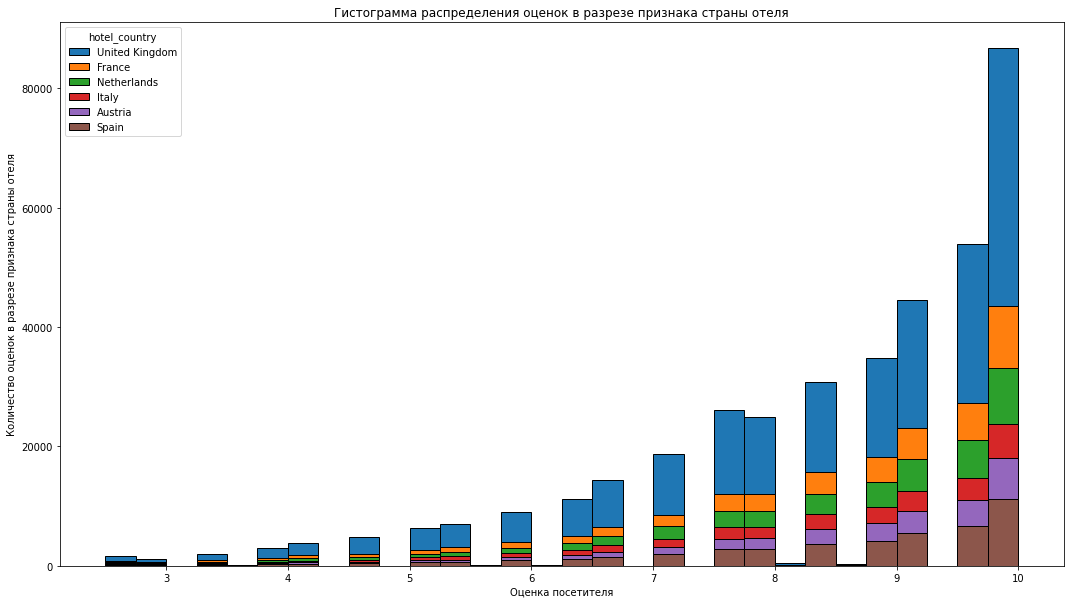

In [62]:
show_reviewer_score_histplot(
        data_hotels, 
        'hotel_country', 
        'Гистограмма распределения оценок в разрезе признака страны отеля', 
        'Количество оценок в разрезе признака страны отеля',
    )

На первый взгляд зависимости нет.\
Распределение примерно равномерное.

### Создание признака hotel_city

In [63]:
def get_hotel_city(address):
    city = ''
    place = get_place(address)
    if (place == 'United Kingdom'):
        city = address.split(' ')[-5]
    else:
        city = address.split(' ')[-2]
    return city

data_hotels['hotel_city'] = data_hotels['hotel_address'].apply(get_hotel_city)

In [64]:
# Добавим описание столбца в список
columns.update({'hotel_city': 'город отеля'})

В каждой стране у нас по одному городу.\
Поэтому по городам распределение будет такое же, как и по странам.

### Создание признака postal_code

Для городов London и Amsterdam индекс расположен на 4 позиции с конца адреса.\
Для остальных городов на 3 позиции с конца адреса.

In [65]:
# Возвращает почтовый индекс из строки с адресом
def get_postal_code(address, city):
    postal_code = ''
    
    if (city in ['London', 'Amsterdam']):
        postal_code = address.split(' ')[-4]
    else:
        postal_code = address.split(' ')[-3]
        
    # Индекс имеет значение только в контексте города. 
    # Поэтому чтобы избежать дублирования индексов из разных городов, добавим в начало название города.
    return city + ' ' + postal_code


# Заполним столбец с индексом
data_hotels['postal_code'] =\
    data_hotels.apply(lambda x: get_postal_code(x['hotel_address'], x['hotel_city']), axis=1)

In [66]:
# Добавим описание столбца в список
columns.update({'postal_code': 'почтовый индекс отеля'})

## 8.2. Уточнение признака hotel_name <a id="item_8_2"></a>

In [67]:
print_column_descriptions(data_hotels, ['hotel_name'])

Признак... : Тип........... : Описание

hotel_name : object........ : название отеля


Посмотрим, сколько отелей в каждом городе.

In [68]:
data_hotels.groupby('hotel_city')['hotel_name'].nunique().sort_values(ascending=False)

hotel_city
Paris        458
London       400
Barcelona    211
Milan        162
Vienna       158
Amsterdam    105
Name: hotel_name, dtype: int64

Посмотрим сумму уникальных значений в каждом городе.

In [69]:
data_hotels.groupby('hotel_city')['hotel_name'].nunique().sum()

1494

Посмотрим общее количество уникальных названий отелей.

In [70]:
data_hotels['hotel_name'].nunique()

1492

Посмотрим на количество уникальных значений широты и долготы

In [71]:
data_hotels['lat'].nunique()

1485

In [72]:
data_hotels['lng'].nunique()

1485

Сумма уникальных названий отелей по городам больше, \
чем количество уникальных названий отелей в целом,\
и больше, чем количество вариантов широты и долготы.\
Это говорит о том, что в разных городах есть отель с одинаковым названием.\
И похоже, что в одном здании может располагаться несколько отелей.\
Поэтому для определения уникальности отеля возьмем поле с его названием.\
И добавим к названию отеля название города, чтобы уникализировать отели с одинаковыми названиями в разных городах.

In [73]:
# Сгруппируем отели по названиям, и посмотрим, для какого названия наибольшее количество городов.
data_hotels.groupby('hotel_name')['hotel_city'].nunique().sort_values(ascending=False).head(3)

hotel_name
Hotel Regina                       3
11 Cadogan Gardens                 1
Mercure Paris Gare Montparnasse    1
Name: hotel_city, dtype: int64

'Hotel Regina' есть в трех городах.\
Посмотрим, в каких.

In [74]:
mask_regina = data_hotels['hotel_name'] == 'Hotel Regina'
data_hotels[mask_regina]['hotel_city'].unique()

array(['Barcelona', 'Vienna', 'Milan'], dtype=object)

Добавим к имени отеля "Hotel Regina" название города, чтобы уникализировать имя.

In [75]:
def get_unique_hotel_name(hotel_name, hotel_city):
    unique_hotel_name = hotel_name
    if (hotel_name == 'Hotel Regina'):
        unique_hotel_name = hotel_name + ' ' + hotel_city
    return unique_hotel_name

data_hotels['hotel_name'] = \
    data_hotels.apply(lambda x: get_unique_hotel_name(x['hotel_name'], x['hotel_city']), axis=1)

Посмотрим на количество уникальных названий отелей.

In [76]:
data_hotels['hotel_name'].nunique()

1494

Теперь их столько же, сколько в сумме по городам.

In [77]:
# Обновим описание столбца в списке
columns.update({'hotel_name': 'название отеля (с добавлением города для дублирующихся названий в разных гродах)'})

## 8.3. Создание признаков по текстовым отзывам <a id="item_8_3"></a>

Вспомним, описания колонок, в которых содержатся данные об отзывах.

In [78]:
text_review_columns = ['negative_review', 'review_total_negative_word_counts',
                           'positive_review', 'review_total_positive_word_counts']
print_column_descriptions(data_hotels, text_review_columns)

Признак.......................... : Тип........... : Описание

negative_review.................. : object........ : отрицательный отзыв, который рецензент дал отелю
review_total_negative_word_counts : int64......... : общее количество слов в отрицательном отзыв
positive_review.................. : object........ : положительный отзыв, который рецензент дал отелю
review_total_positive_word_counts : int64......... : общее количество слов в положительном отзыве


Посмотрим их содержимое.

In [79]:
data_hotels[text_review_columns].head(5)

,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts
0,Leaving,3,Staff were amazing,4
1,poor breakfast,3,location,2
2,No kettle in room,6,NaN,0
3,NaN,0,Friendly staff quiet comfortable room spotless...,11
4,Torn sheets,4,The staff was very friendly and helpful Breakf...,20


Пересчитаем количество слов в отзывах, потому что по первым строчкам видно, что оно не совсем верное.

In [80]:
def get_review_word_counts(review):
    if (pd.isnull(review)):
        return 0
    review_words_list = review.split()
    return len(review_words_list)

data_hotels['review_total_negative_word_counts'] = \
    data_hotels['negative_review'].apply(get_review_word_counts)

data_hotels['review_total_positive_word_counts'] = \
    data_hotels['positive_review'].apply(get_review_word_counts)

Посмотрим на результат.

In [81]:
data_hotels[text_review_columns].head(5)

,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts
0,Leaving,1,Staff were amazing,3
1,poor breakfast,2,location,1
2,No kettle in room,4,NaN,0
3,NaN,0,Friendly staff quiet comfortable room spotless...,9
4,Torn sheets,2,The staff was very friendly and helpful Breakf...,18


Теперь значения выглядят правильными.

Посмотрим, как зависит оценка от количества слов в негативном и позитивном отзывах.

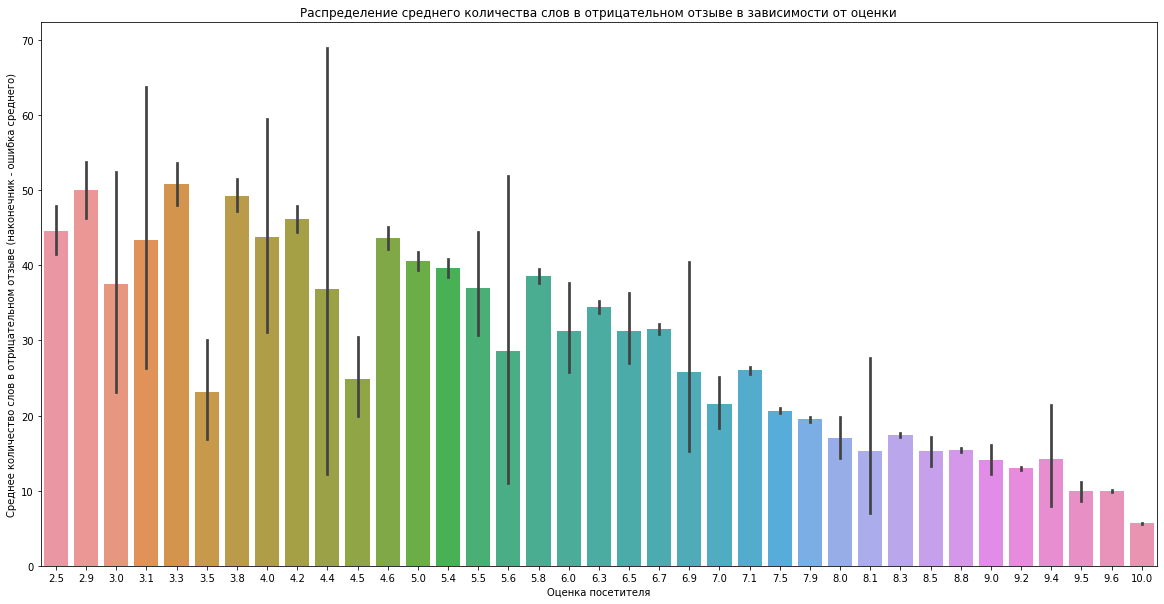

In [82]:
show_reviewer_score_barplot(
        data_hotels, 
        'review_total_negative_word_counts', 
        'Распределение среднего количества слов в отрицательном отзыве в зависимости от оценки', 
        'Среднее количество слов в отрицательном отзыве',
    )

Наблюдается зависимость - чем выше оценка, тем меньше в среднем слов в отрицательном отзыве.

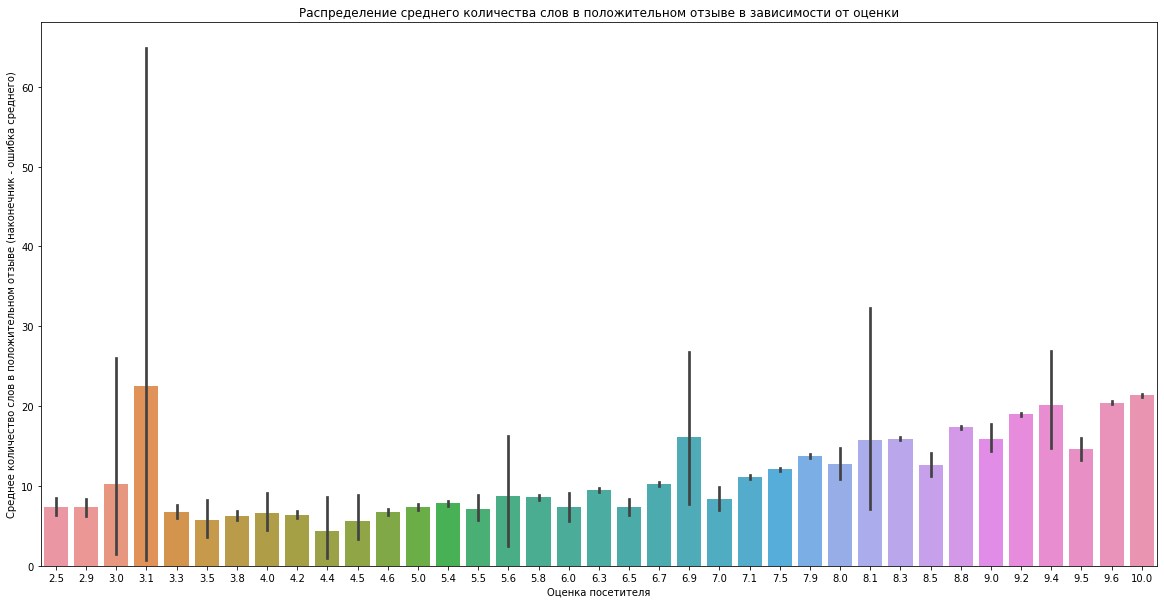

In [83]:
show_reviewer_score_barplot(
        data_hotels, 
        'review_total_positive_word_counts', 
        'Распределение среднего количества слов в положительном отзыве в зависимости от оценки', 
        'Среднее количество слов в положительном отзыве',
    )

Здесь зависимость менее явная, чем выше.\
Но тоже наблюдается зависимость - для более высоких оценок количество слов в положительном отзыве больше.

### Создание признаков с общим количеством положительных и отрицательных отзывов об отелях (total_positive_reviews и total_negative_reviews)

##### Создание признака total_positive_reviews

In [84]:
positive_review_mask = data_hotels['review_total_positive_word_counts'] > 0

count_positive_reviews = data_hotels[positive_review_mask]\
    .groupby('hotel_name')['review_total_positive_word_counts'].count()

data_hotels = data_hotels.merge(count_positive_reviews, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'review_total_positive_word_counts_y': 'total_positive_reviews'})

# Добавим описание столбца в список
columns.update({'total_positive_reviews': 'общее количество положительных отзывов у отеля'})

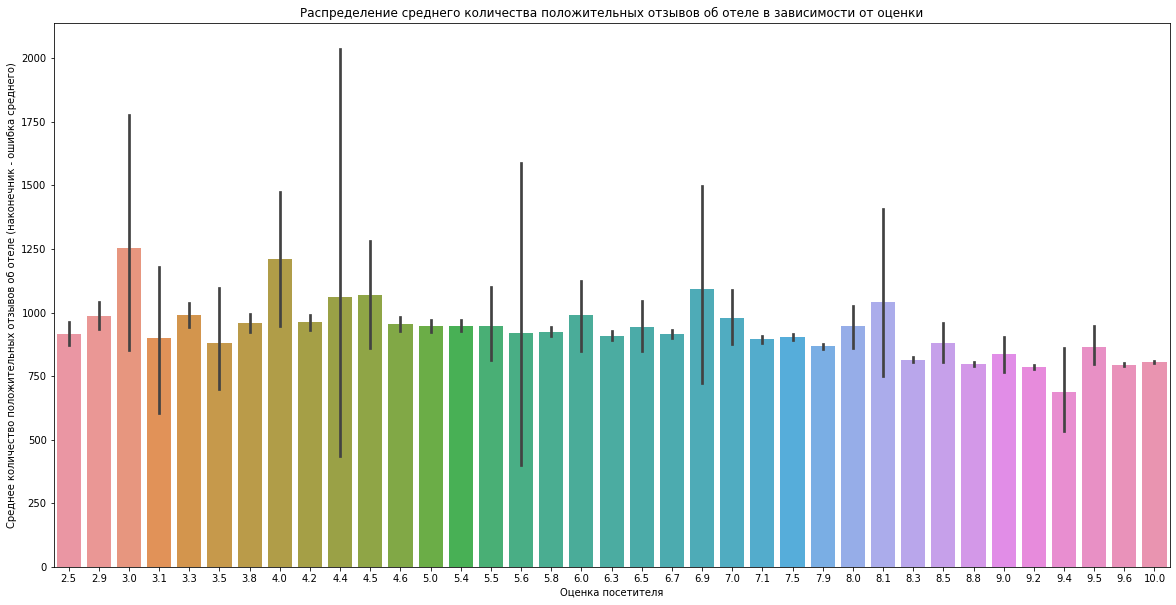

In [85]:
show_reviewer_score_barplot(
        data_hotels, 
        'total_positive_reviews', 
        'Распределение среднего количества положительных отзывов об отеле в зависимости от оценки', 
        'Среднее количество положительных отзывов об отеле',
    )

Сильной зависимости не наблюдается.\
Можно заметить, что у бОльших оценок среднее количество положительных отзывов об отеле меньше.\
Что несколько странно.\
Кажется, что должно быть наоборот.

##### Создание признака total_negative_reviews

In [86]:
negative_review_mask = data_hotels['review_total_negative_word_counts'] > 0

count_negative_reviews = data_hotels[negative_review_mask]\
    .groupby('hotel_name')['review_total_negative_word_counts'].count()

data_hotels = data_hotels.merge(count_negative_reviews, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'review_total_negative_word_counts_y': 'total_negative_reviews'})

# Добавим описание столбца в список
columns.update({'total_negative_reviews': 'общее количество отрицательных отзывов у отеля'})

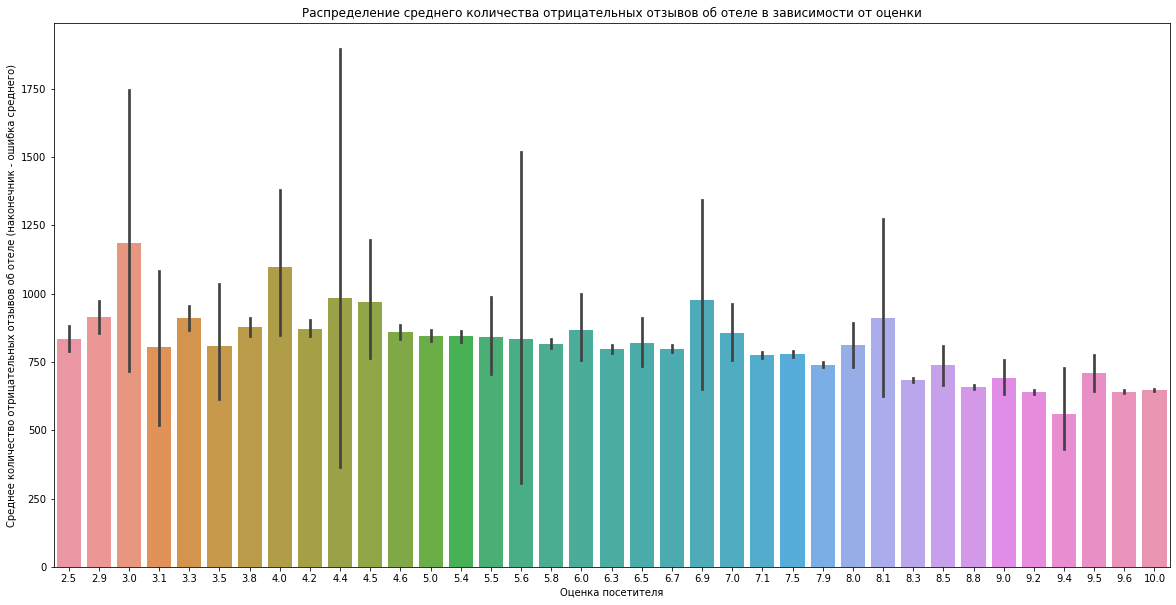

In [87]:
show_reviewer_score_barplot(
        data_hotels, 
        'total_negative_reviews', 
        'Распределение среднего количества отрицательных отзывов об отеле в зависимости от оценки', 
        'Среднее количество отрицательных отзывов об отеле',
    )

Тут наблюдается более явная закономерность.\
При более высоких оценках среднее количество отрицательных отзывов об отеле меньше.\
И это ожидаемо.

### Создание численных оценок отызвов с помощью библиотеки nltk

VADER’s `SentimentIntensityAnalyzer()` принимает строку и возвращает словарь оценок в каждой из четырех категорий:
- отрицательный
- нейтральный
- положительный
- составной (вычисляется путем нормализации приведенных выше оценок)

In [88]:
sid = SentimentIntensityAnalyzer()

def get_scores(review):
    """Возвращает словарь с оценками тональности отзыва
    Args:
        review (str): текст отзыва
    Returns:
        dict: словарь с оценками отзывов
    """
    review_result = review
    if (pd.isna(review)):
        review_result = ''
    return sid.polarity_scores(review_result)  


data_hotels['positive_scores'] = data_hotels['positive_review'].apply(get_scores)    
data_hotels['negative_scores'] = data_hotels['negative_review'].apply(get_scores)

columns.update({
    'positive_scores': 'словарь с оценками тональности позитивного отзыва',
    'negative_scores': 'словарь с оценками тональности негативного отзыва',
})

Проверим, что данные заполнились.

In [89]:
for scores in data_hotels['negative_scores'].head(4):
    print(scores)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'compound': -0.296}
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}


In [90]:
for scores in data_hotels['positive_scores'].head(4):
    print(scores)

{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.5859}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.279, 'pos': 0.721, 'compound': 0.9169}


Разложим оценки по отдельным столбцам.

In [91]:
def get_score_value(scores, score_name):
    """Возвращает значение отдельной оценки из словаря
    Args:
        scores (dict): словарь с оценками
        score_name (str): ключ оценки, которую нужно вернуть
    Returns:
        float: значение оценки
    """
    return scores.get(score_name)

In [92]:
data_hotels['negative_neg'] = data_hotels\
    .apply(lambda x: get_score_value(x['negative_scores'], 'neg'), axis=1)
data_hotels['negative_neu'] = data_hotels\
    .apply(lambda x: get_score_value(x['negative_scores'], 'neu'), axis=1)
data_hotels['negative_pos'] = data_hotels\
    .apply(lambda x: get_score_value(x['negative_scores'], 'pos'), axis=1)
data_hotels['negative_compound'] = data_hotels\
    .apply(lambda x: get_score_value(x['negative_scores'], 'compound'), axis=1)

In [93]:
columns.update({
    'negative_neg': 'коэффициент тональности негативного отзыва (отрицательный)',
    'negative_neu': 'коэффициент тональности негативного отзыва (нейтральный)',
    'negative_pos': 'коэффициент тональности негативного отзыва (положительный)',
    'negative_compound': 'коэффициент тональности негативного отзыва (составной)',
})

In [94]:
data_hotels['positive_neg'] = data_hotels\
    .apply(lambda x: get_score_value(x['positive_scores'], 'neg'), axis=1)
data_hotels['positive_neu'] = data_hotels\
    .apply(lambda x: get_score_value(x['positive_scores'], 'neu'), axis=1)
data_hotels['positive_pos'] = data_hotels\
    .apply(lambda x: get_score_value(x['positive_scores'], 'pos'), axis=1)
data_hotels['positive_compound'] = data_hotels\
    .apply(lambda x: get_score_value(x['positive_scores'], 'compound'), axis=1)

In [95]:
columns.update({
    'positive_neg': 'коэффициент тональности позитивного отзыва (отрицательный)',
    'positive_neu': 'коэффициент тональности позитивного отзыва (нейтральный)',
    'positive_pos': 'коэффициент тональности позитивного отзыва (положительный)',
    'positive_compound': 'коэффициент тональности позитивного отзыва (составной)',
})

Оценка **compound** содержит итоговое значение тональности отзыва.\
Если она **больше 0**, библиотека nltk оценила отзыв как **позитивный**.\
Если если **меньше 0**, то как **негативный**.\
Если **равно 0**, то как **нейтральный** или не достаточно критериев для оценки.

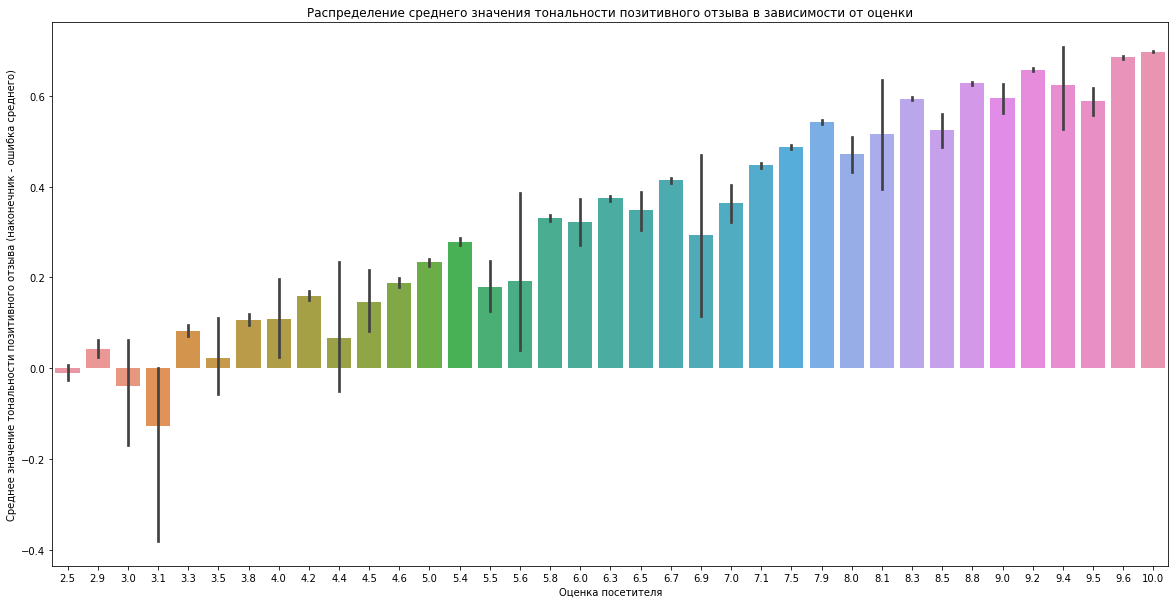

In [96]:
show_reviewer_score_barplot(
        data_hotels, 
        'positive_compound', 
        'Распределение среднего значения тональности позитивного отзыва в зависимости от оценки', 
        'Среднее значение тональности позитивного отзыва',
    )

Тут наблюдается явная зависимость, что у более высоких оценок бОльшее среднее значение у признака positive_compound.\
Для оценок близких к трем среднее значение positive_compound отрицательное.\
Скорее всего это говорит о том, что отрицательный отзыв написали в поле для положительного.

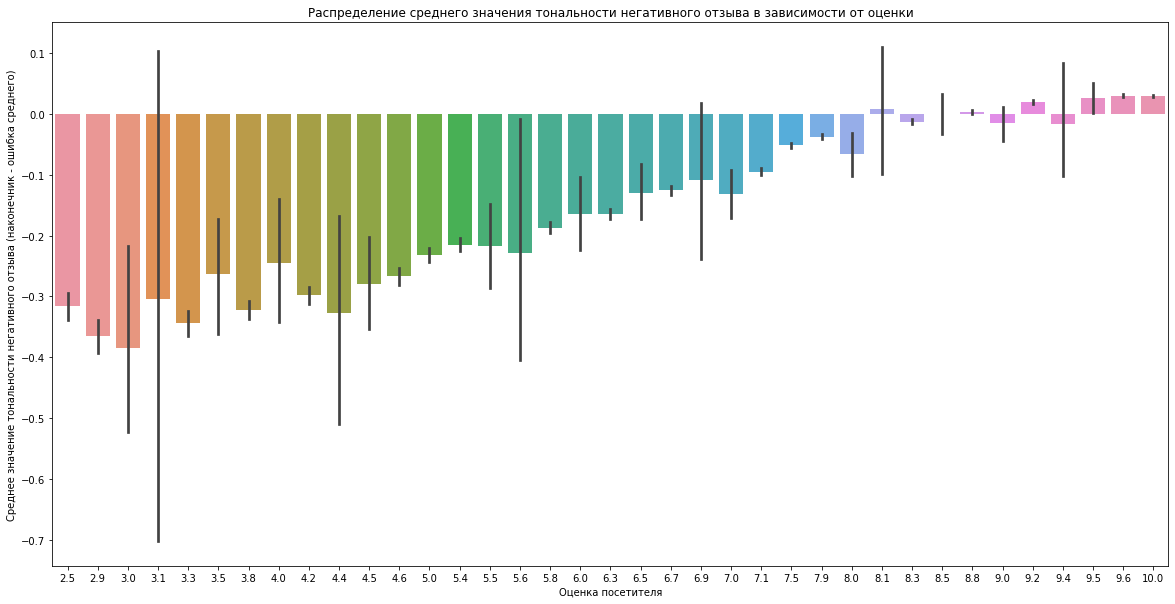

In [97]:
show_reviewer_score_barplot(
        data_hotels, 
        'negative_compound', 
        'Распределение среднего значения тональности негативного отзыва в зависимости от оценки', 
        'Среднее значение тональности негативного отзыва',
    )

Для меньших оценок наблюдаем меньшие значения negative_compound,\
а для больших - большие.\
Для оценок больше 9 значения negative_compound даже уходят в плюс.\
Возможно, что в поле для негативного отзыва записан позитивный.

Определим тональность текстов обоих отзывов с помощью значения **compound**.\
И посчитаем итоговое количество слов отзывов в положительном или отрицательном ключе.\
Значения занесем в признаки **total_positive_word_counts** и **total_negative_word_counts**.

In [98]:
# Вспомним описание содержимого столбцов
review_columns = [
    'positive_review', 'positive_compound', 'review_total_positive_word_counts',
    'negative_review', 'negative_compound', 'review_total_negative_word_counts',
]

print_column_descriptions(data_hotels, review_columns)

Признак.......................... : Тип........... : Описание

positive_review.................. : object........ : положительный отзыв, который рецензент дал отелю
positive_compound................ : float64....... : коэффициент тональности позитивного отзыва (составной)
review_total_positive_word_counts : int64......... : общее количество слов в положительном отзыве
negative_review.................. : object........ : отрицательный отзыв, который рецензент дал отелю
negative_compound................ : float64....... : коэффициент тональности негативного отзыва (составной)
review_total_negative_word_counts : int64......... : общее количество слов в отрицательном отзыв


In [99]:
# Возвращает количество слов в отзывах, написанных в позитивном ключе.
# Имена входящих параметров соответствуют именам столбцов таблицы.
def get_total_positive_word_counts(
        positive_review, positive_compound, review_total_positive_word_counts,
        negative_review, negative_compound, review_total_negative_word_counts,
    ):
    sum = 0
    if (positive_compound >= 0):
        sum += review_total_positive_word_counts
    if (negative_compound > 0 and positive_review != negative_review):
        sum += review_total_negative_word_counts
    return sum


# Возвращает количество слов в отзывах, написанных в негативном ключе.
# Имена входящих параметров соответствуют именам столбцов таблицы.
def get_total_negative_word_counts(
        positive_review, positive_compound, review_total_positive_word_counts,
        negative_review, negative_compound, review_total_negative_word_counts,
    ):
    sum = 0
    if (positive_compound < 0 and positive_review != negative_review):
        sum += review_total_positive_word_counts
    if (negative_compound <= 0):
        sum += review_total_negative_word_counts
    return sum


# Заполним данные по столбцам
data_hotels['total_positive_word_counts'] =  data_hotels.apply(
    lambda x: get_total_positive_word_counts(
        x['positive_review'], x['positive_compound'], x['review_total_positive_word_counts'],
        x['negative_review'], x['negative_compound'], x['review_total_negative_word_counts'],
    ), 
    axis=1
)

data_hotels['total_negative_word_counts'] =  data_hotels.apply(
    lambda x: get_total_negative_word_counts(
        x['positive_review'], x['positive_compound'], x['review_total_positive_word_counts'],
        x['negative_review'], x['negative_compound'], x['review_total_negative_word_counts'],
    ), 
    axis=1
)

# Сохраним описание содержимого столбцов
columns.update({
    'total_positive_word_counts': 'общее количество слов в отзывых в позитивном ключе',
    'total_negative_word_counts': 'общее количество слов в отзывах в негативном ключе',
})

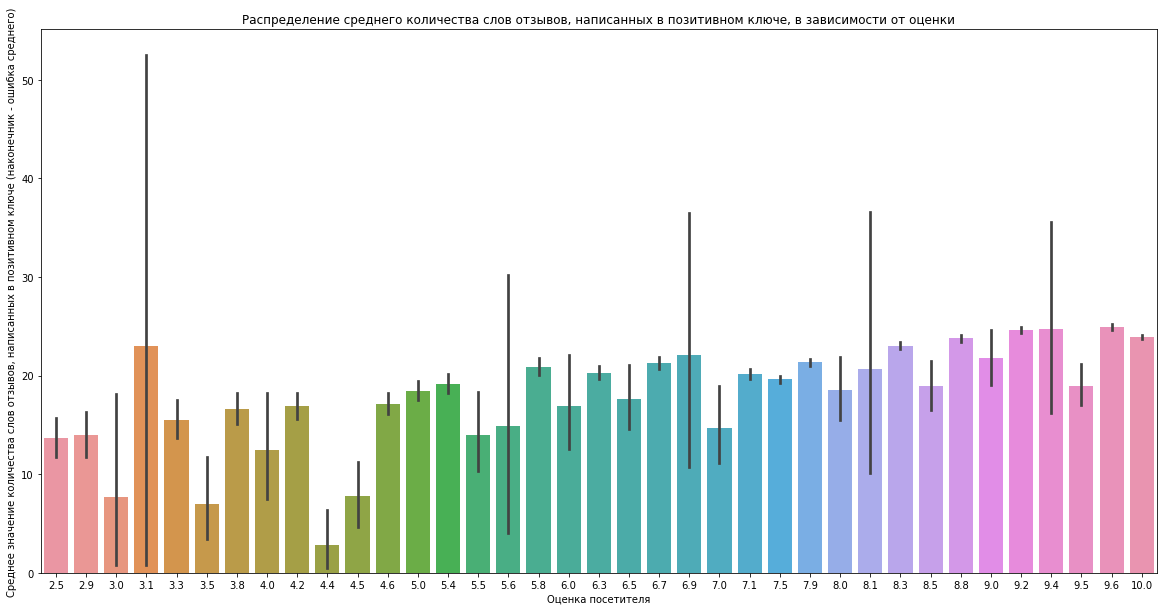

In [100]:
show_reviewer_score_barplot(
        data_hotels, 
        'total_positive_word_counts', 
        'Распределение среднего количества слов отзывов, написанных в позитивном ключе, в зависимости от оценки', 
        'Среднее значение количества слов отзывов, написанных в позитивном ключе',
    )

Тут наблюдается гораздо менее очевидный рост вверх, чем на графике для признака. **review_total_positive_word_counts**.

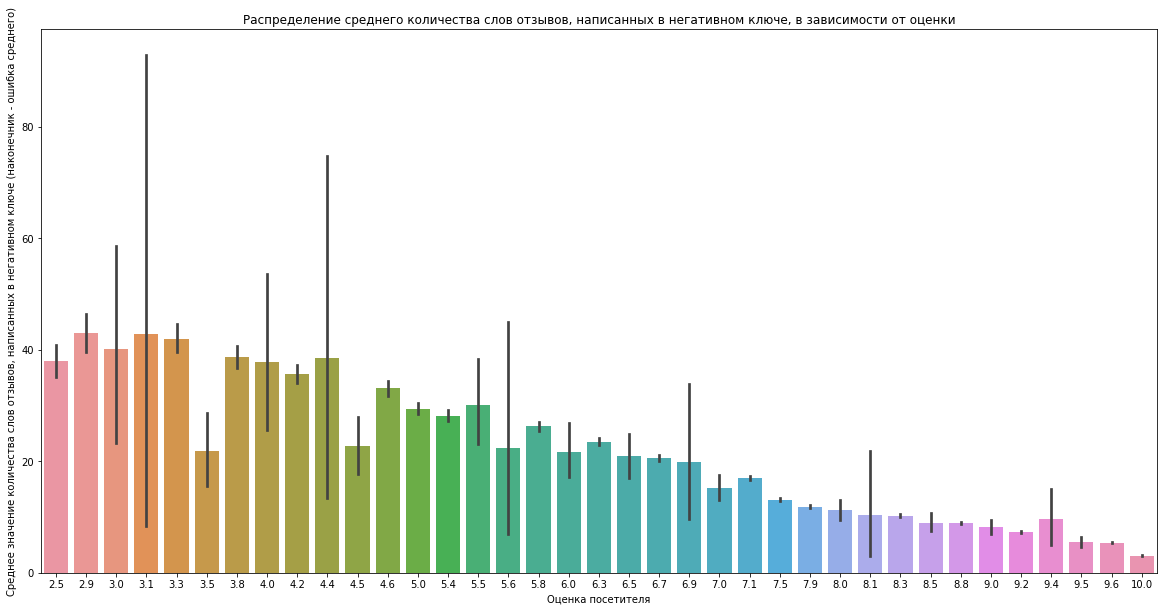

In [101]:
show_reviewer_score_barplot(
        data_hotels, 
        'total_negative_word_counts', 
        'Распределение среднего количества слов отзывов, написанных в негативном ключе, в зависимости от оценки', 
        'Среднее значение количества слов отзывов, написанных в негативном ключе',
    )

А здесь наблюдается более плавное снижение среднего значения, чем для признака **review_total_negative_word_counts**.

В целом из этого можно сделать предположение, что библиотека nltk не всегда верно отличает положительную тональность от отрицательной.

Посчитаем среднее и медиану для признаков **total_positive_word_counts** и **total_negative_word_counts** по отелю.\
И занесем эти значения в признаки \
**total_positive_word_counts_mean**, **total_positive_word_counts_median**\
и\
**total_negative_word_counts_mean**, **total_negative_word_counts_median**\
соответственно.

In [102]:
# среднее количество слов в позитивном ключе по отелю
total_positive_word_counts_mean = data_hotels\
    .groupby('hotel_name')['total_positive_word_counts'].mean()

data_hotels = data_hotels.merge(total_positive_word_counts_mean, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'total_positive_word_counts_y': 'total_positive_word_counts_mean'})

columns.update({'total_positive_word_counts_mean': 'среднее значение total_positive_word_counts по отелю'})

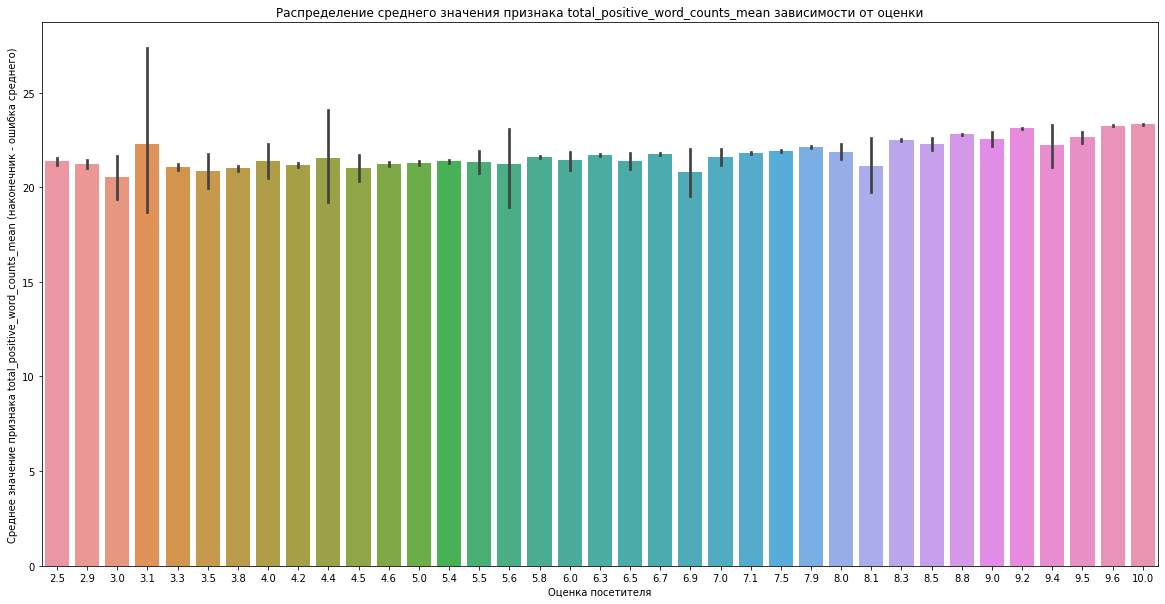

In [103]:
show_reviewer_score_barplot(
        data_hotels, 
        'total_positive_word_counts_mean', 
        'Распределение среднего значения признака total_positive_word_counts_mean зависимости от оценки', 
        'Среднее значение признака total_positive_word_counts_mean',
    )

Наблюдается очень небольшой рост вверх.\
То есть, зависимость есть, но небольшая.

In [104]:
# медиана количества слов в позитивном ключе по отелю
total_positive_word_counts_median = data_hotels\
    .groupby('hotel_name')['total_positive_word_counts'].median()

data_hotels = data_hotels.merge(total_positive_word_counts_median, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'total_positive_word_counts_y': 'total_positive_word_counts_median'})

columns.update({'total_positive_word_counts_median': 'медиана значения total_positive_word_counts по отелю'})

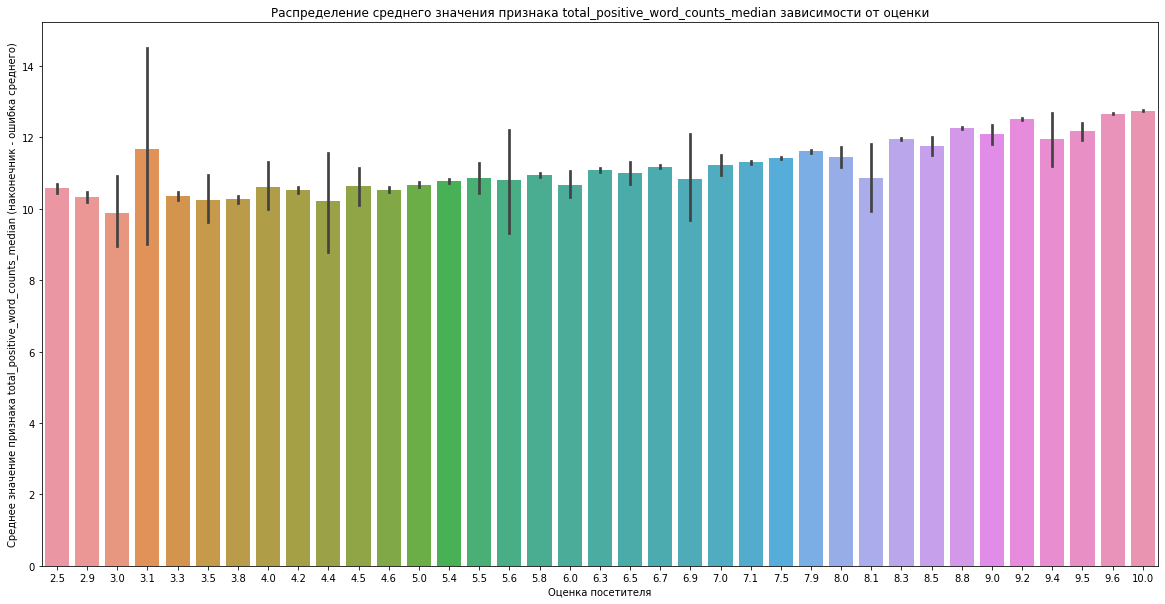

In [105]:
show_reviewer_score_barplot(
        data_hotels, 
        'total_positive_word_counts_median', 
        'Распределение среднего значения признака total_positive_word_counts_median зависимости от оценки', 
        'Среднее значение признака total_positive_word_counts_median',
    )

Также наблюдается небольшой рост значений.\
Опять же можно сделать предположение о слабой зависимости.

In [106]:
# среднее количество слов в негативном ключе по отелю
total_negative_word_counts_mean = data_hotels\
    .groupby('hotel_name')['total_negative_word_counts'].mean()

data_hotels = data_hotels.merge(total_negative_word_counts_mean, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'total_negative_word_counts_y': 'total_negative_word_counts_mean'})

columns.update({'total_negative_word_counts_mean': 'среднее значение total_negative_word_counts по отелю'})

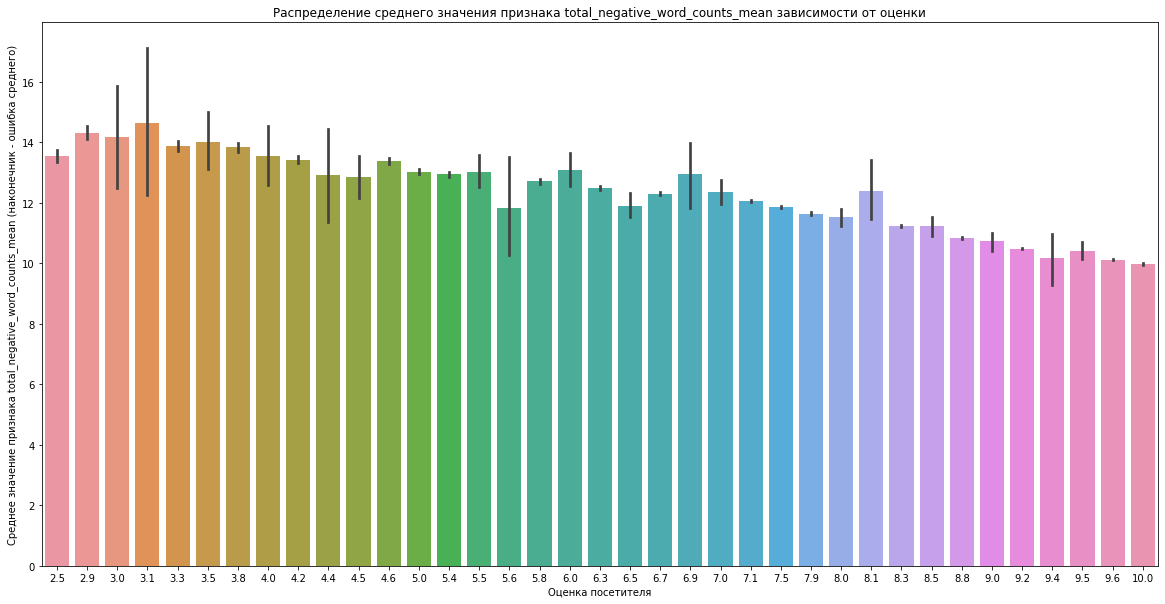

In [107]:
show_reviewer_score_barplot(
        data_hotels, 
        'total_negative_word_counts_mean', 
        'Распределение среднего значения признака total_negative_word_counts_mean зависимости от оценки', 
        'Среднее значение признака total_negative_word_counts_mean',
    )

А здесь наблюдается плавное уменьшение значений.\
То есть, зависимость имеет место быть.

In [108]:
# медиана количества слов в негативном ключе по отелю
total_negative_word_counts_median = data_hotels\
    .groupby('hotel_name')['total_negative_word_counts'].median()

data_hotels = data_hotels.merge(total_negative_word_counts_median, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'total_negative_word_counts_y': 'total_negative_word_counts_median'})

columns.update({'total_negative_word_counts_median': 'медиана значения total_negative_word_counts по отелю'})

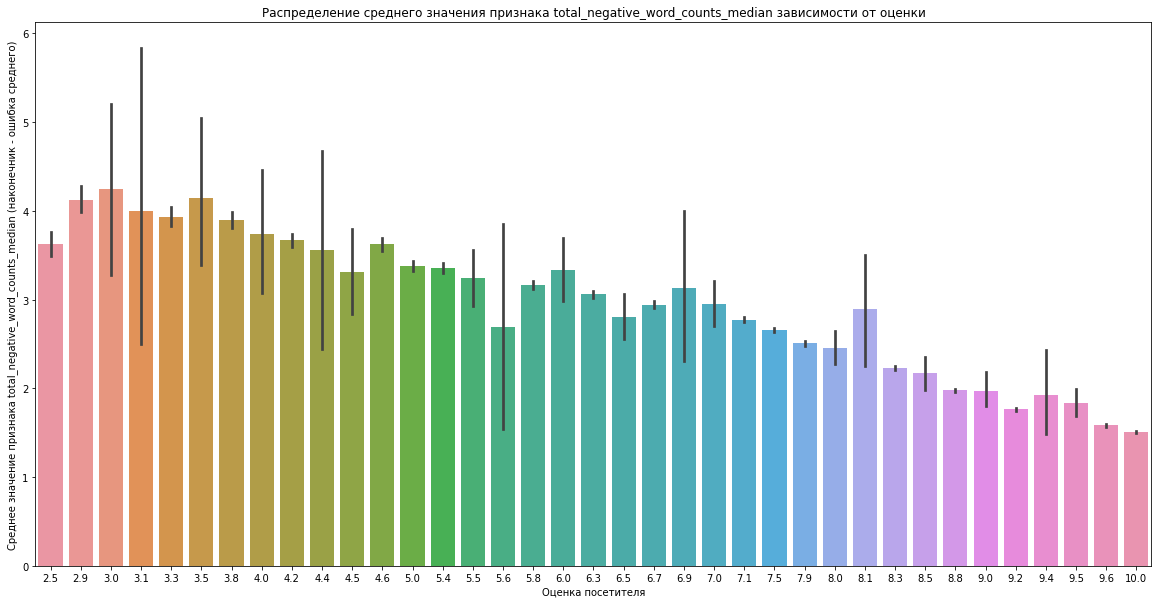

In [109]:
show_reviewer_score_barplot(
        data_hotels, 
        'total_negative_word_counts_median', 
        'Распределение среднего значения признака total_negative_word_counts_median зависимости от оценки', 
        'Среднее значение признака total_negative_word_counts_median',
    )

Заметно более явное уменьшение значений для хороших оценок.\
То есть, зависимость есть.

Вспомним описание содержимого столбцов, с которыми дальше будем работать.

In [110]:
review_columns = [
    'positive_compound', 'total_positive_word_counts',
    'negative_compound', 'total_negative_word_counts',
]
print_column_descriptions(data_hotels, review_columns)

Признак................... : Тип........... : Описание

positive_compound......... : float64....... : коэффициент тональности позитивного отзыва (составной)
total_positive_word_counts : int64......... : общее количество слов в отзывых в позитивном ключе
negative_compound......... : float64....... : коэффициент тональности негативного отзыва (составной)
total_negative_word_counts : int64......... : общее количество слов в отзывах в негативном ключе


Создадим промежуточный признак **review_coefficient**.\
Положим в него кортеж из двух значений.\
В первом значении будет произведение **positive_compound * total_positive_word_counts**.\
Во втором значении будет произведение **negative_compound * total_negative_word_counts**.

То есть для текстов отзывов в положительном и отрицательном ключе мы создадим коэффициенты путем\
умножения итоговой оценки **compound** на количество слов.

Возможно, это даст более сильный признак, который будет характеризовать позитивный или негативный отзыв.

То есть, допустим, три пользователя написали положительные отзывы по 10 слов.
- у первого отзыва  ***compound = 0*** (говорит о нейтральной тональности), 
- у второго ***compound = 0.1*** (говорит о слабо позитивной тональности), 
- у третьего ***compound = 0.9*** (говорит о сильно позитивной тональности)

Умножая значения **compound** на 10 (количество слов), \
мы в трех случаях получим более явный признак, который говорит о том, насколько позитивный отзыв.

Аналогично с негативными отзывами.

In [111]:
# Возвращает кортеж из коэффициентов для отзывов в позитивном и негативном ключе.
# Имена параметров соответствуют именам столбцов таблицы.
def get_review_coefficient(
        positive_compound,
        total_positive_word_counts,
        negative_compound,
        total_negative_word_counts,
    ):
    positive_review_coeff = total_positive_word_counts * positive_compound
    negative_review_coeff = total_negative_word_counts * negative_compound
    
    return (positive_review_coeff, negative_review_coeff)


# Заполним столбец значениями
data_hotels['review_coefficient'] =  data_hotels.apply(
    lambda x: get_review_coefficient(
        x['positive_compound'], x['total_positive_word_counts'],
        x['negative_compound'], x['total_negative_word_counts'],
    ), 
    axis=1
)

# Запомним описание содержимого столбца
columns.update({
    'review_coefficient': 'Кортеж с произведением количества слов в отзывах на их итоговую оценку compound',
})

In [112]:
# Проверим, что значения заполнились
data_hotels['review_coefficient'].head(5)

0     (1.7576999999999998, 0.0)
1                (0.0, -0.9534)
2                 (0.0, -1.184)
3                 (8.2521, 0.0)
4    (15.305399999999999, -0.5)
Name: review_coefficient, dtype: object

Теперь каждое значение из кортежа в поле **review_coefficient** перенесем в свой столбец.\
Столбец **review_positive_coefficient** будет содержать коэффициент для отзыва в позитивном ключе.\
Столбец **review_negative_coefficient** будет содержать модуль коэффициента для отзыва в негативном ключе.

In [113]:
# Возвращает коэффициент для отзыва в позитивном ключе
def get_review_positive_coefficient(review_coefficient):
    return review_coefficient[0]

# Возвращает коэффициент для отзыва в негативном ключе
def get_review_negative_coefficient(review_coefficient):
    return abs(review_coefficient[1])

# Заполним значения новых столбцов
data_hotels['review_positive_coefficient'] = data_hotels['review_coefficient'].apply(get_review_positive_coefficient)
data_hotels['review_negative_coefficient'] = data_hotels['review_coefficient'].apply(get_review_negative_coefficient)

# Сохраним описания столбцов
columns.update({
    'review_positive_coefficient': 
        'Коэффициент для отзыва в позитивном ключе (произведение compound на количество слов)',
    'review_negative_coefficient': 
        'Коэффициент для отзыва в негативном ключе (произведение compound на количество слов)',
})

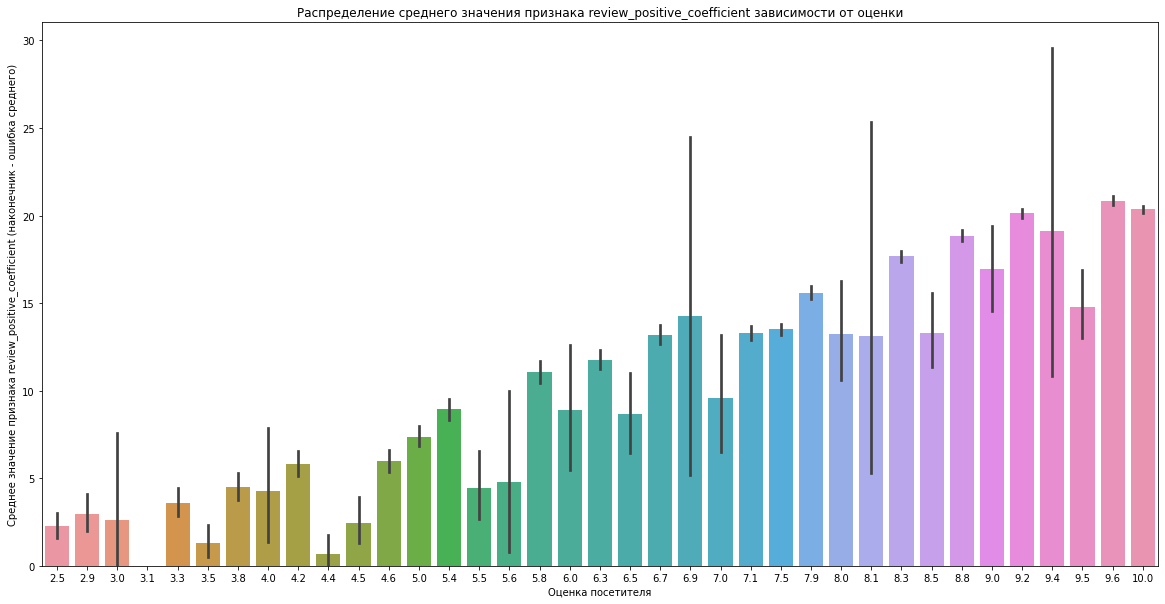

In [114]:
show_reviewer_score_barplot(
        data_hotels, 
        'review_positive_coefficient', 
        'Распределение среднего значения признака review_positive_coefficient зависимости от оценки', 
        'Среднее значение признака review_positive_coefficient'
    )

Наблюдается не плавный, но заметный рост значений вверх.\
Чем выше оценка, тем больше коэффициент.\
Можно предположить, что удалось сделать более сильный признак.

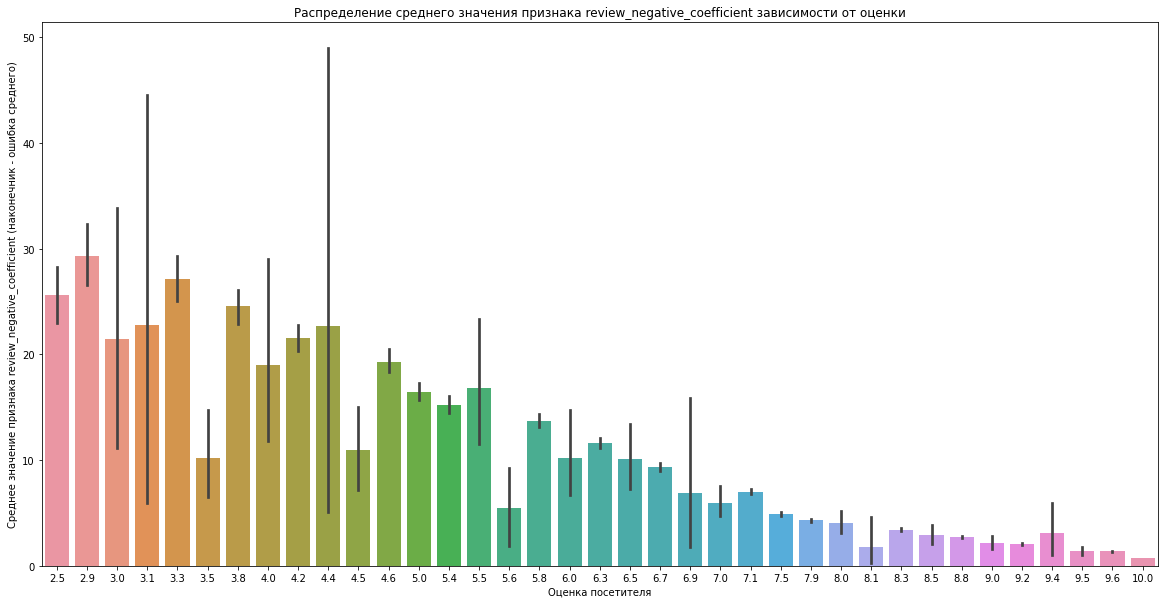

In [115]:
show_reviewer_score_barplot(
        data_hotels, 
        'review_negative_coefficient', 
        'Распределение среднего значения признака review_negative_coefficient зависимости от оценки', 
        'Среднее значение признака review_negative_coefficient'
    )

Опять же наблюдаетя не плавное, но заметное снижение значений.\
Чем больше оценка, тем меньше коэффициент.\
Можно предположить, что удалось создать более сильный признак.

Теперь для признаков **review_positive_coefficient** и **review_negative_coefficient**\
по всем отелям посчитаем два агрегирующие признака: \
среднее и медиану

Соответственно назовем признаки:

**review_positive_coefficient_mean**\
**review_positive_coefficient_median**

**review_negative_coefficient_mean**\
**review_negative_coefficient_median**

Потом посмотрим, какие из созданных признаков будут иметь в итоге бОльшее значение для модели.\
Их и оставим.

In [116]:
# считаем среднее значение признака review_positive_coefficient
review_positive_coefficient_mean = data_hotels\
    .groupby('hotel_name')['review_positive_coefficient'].mean()

data_hotels = data_hotels.merge(review_positive_coefficient_mean, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'review_positive_coefficient_y': 'review_positive_coefficient_mean'})

columns.update({'review_positive_coefficient_mean': 'среднее значение признака review_positive_coefficient по отелю'})

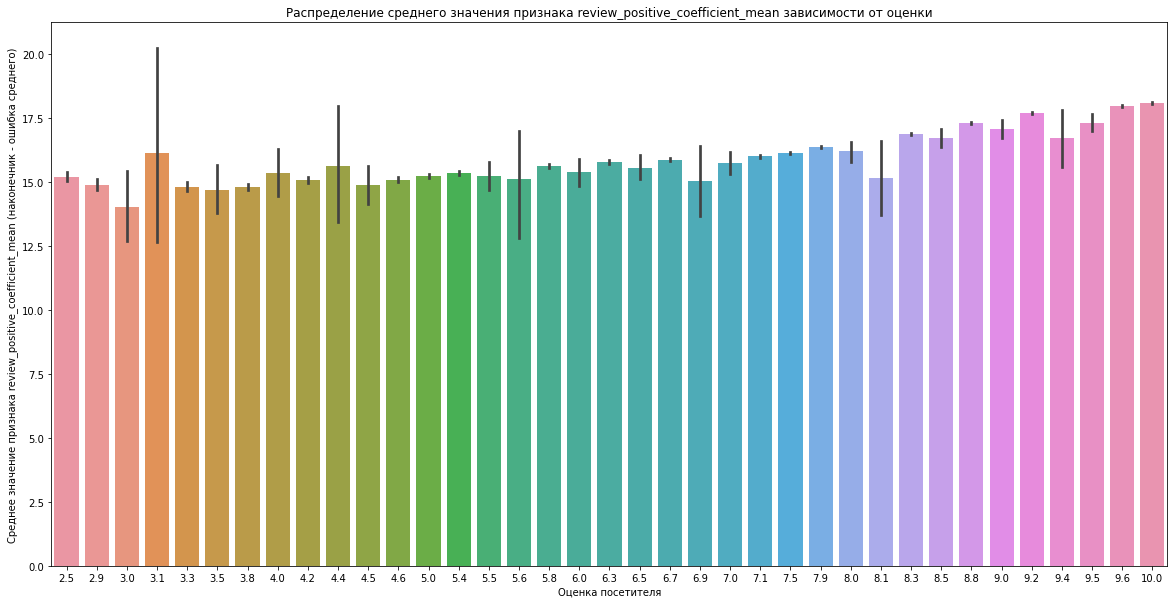

In [117]:
show_reviewer_score_barplot(
        data_hotels, 
        'review_positive_coefficient_mean', 
        'Распределение среднего значения признака review_positive_coefficient_mean зависимости от оценки', 
        'Среднее значение признака review_positive_coefficient_mean'
    )

Наблюдается незначительный рост значений при увеличении оценки.\
ПОхоже, что связь есть, но слабая.

In [118]:
# считаем медиану признака review_positive_coefficient
review_positive_coefficient_median = data_hotels\
    .groupby('hotel_name')['review_positive_coefficient'].median()

data_hotels = data_hotels.merge(review_positive_coefficient_median, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'review_positive_coefficient_y': 'review_positive_coefficient_median'})

columns.update({'review_positive_coefficient_median': 'медиана признака review_positive_coefficient по отелю'})

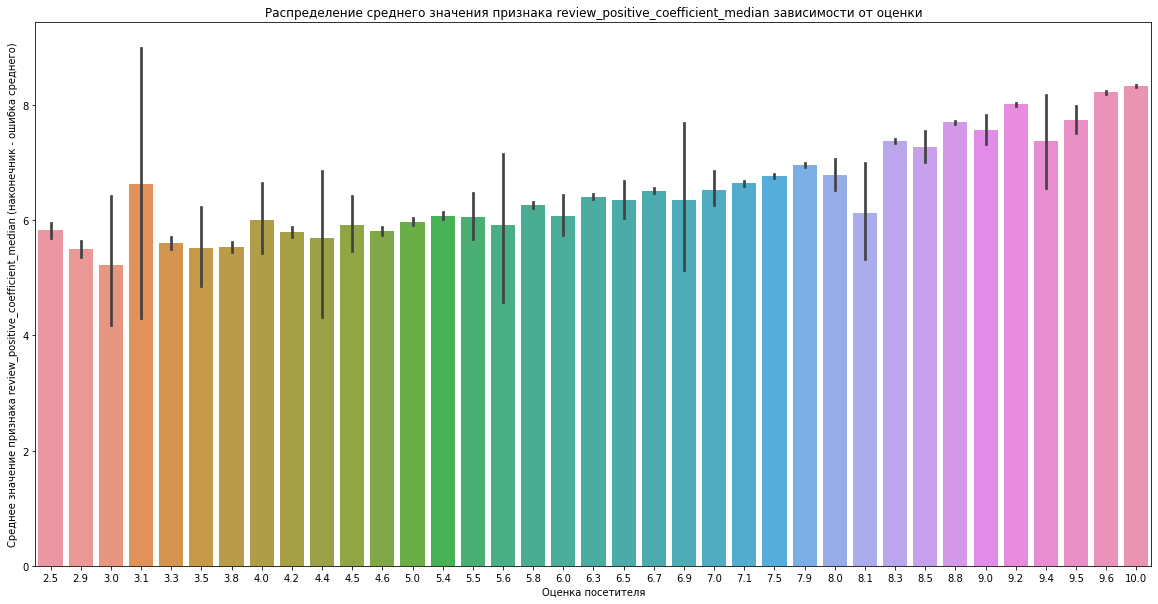

In [119]:
show_reviewer_score_barplot(
        data_hotels, 
        'review_positive_coefficient_median', 
        'Распределение среднего значения признака review_positive_coefficient_median зависимости от оценки', 
        'Среднее значение признака review_positive_coefficient_median'
    )

Наблюдается более заметный рост значений при увеличении оценки.\
Можно сделать вывод, что есть более сильная связь, чем в предыдущем случае.

In [120]:
# считаем среднее значение признака review_negative_coefficient
review_negative_coefficient_mean = data_hotels\
    .groupby('hotel_name')['review_negative_coefficient'].mean()

data_hotels = data_hotels.merge(review_negative_coefficient_mean, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'review_negative_coefficient_y': 'review_negative_coefficient_mean'})

columns.update({'review_negative_coefficient_mean': 'среднее значение признака review_negative_coefficient по отелю'})

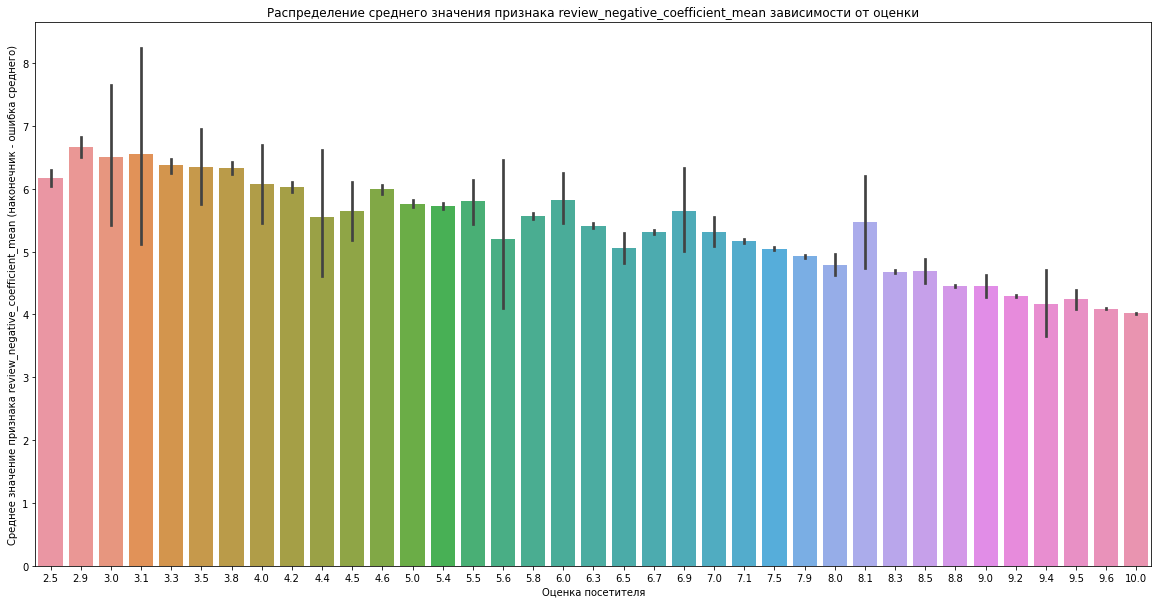

In [121]:
show_reviewer_score_barplot(
        data_hotels, 
        'review_negative_coefficient_mean', 
        'Распределение среднего значения признака review_negative_coefficient_mean зависимости от оценки', 
        'Среднее значение признака review_negative_coefficient_mean'
    )

Чем меньше оценка, тем меньше значение признака.\
Связь есть.

In [122]:
# считаем медиану признака review_negative_coefficient
review_negative_coefficient_median = data_hotels\
    .groupby('hotel_name')['review_negative_coefficient'].median()

data_hotels = data_hotels.merge(review_negative_coefficient_median, on='hotel_name', how='left', suffixes=(None, '_y'))

data_hotels = data_hotels.rename(columns={'review_negative_coefficient_y': 'review_negative_coefficient_median'})

columns.update({'review_negative_coefficient_median': 'медиана признака review_negative_coefficient по отелю'})

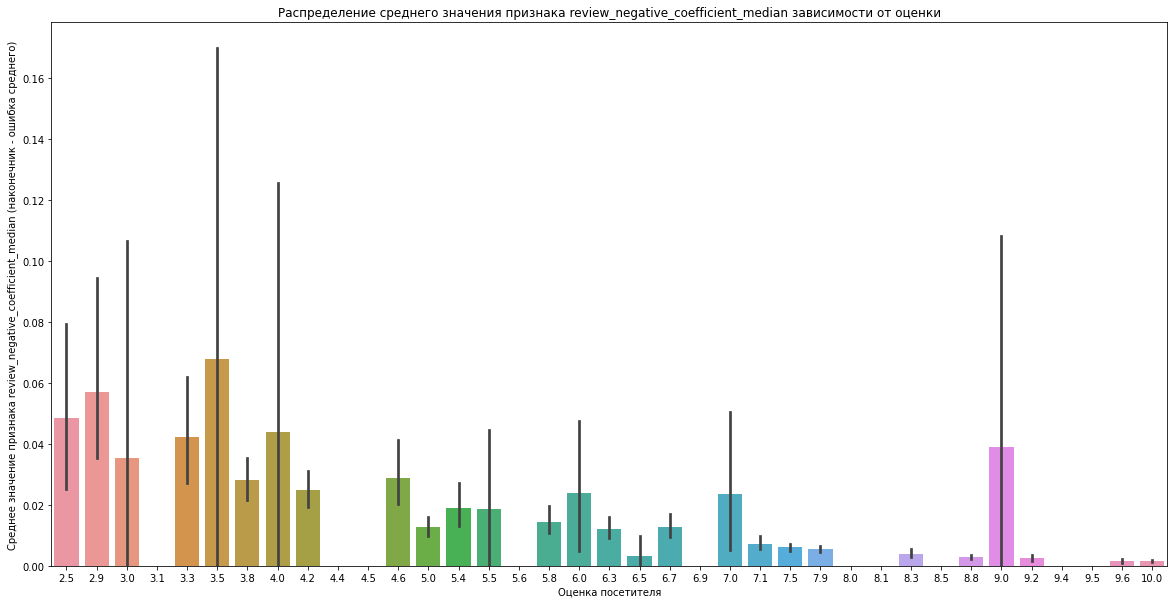

In [123]:
show_reviewer_score_barplot(
        data_hotels, 
        'review_negative_coefficient_median', 
        'Распределение среднего значения признака review_negative_coefficient_median зависимости от оценки', 
        'Среднее значение признака review_negative_coefficient_median'
    )

Здесь весьма не плавное распределение.\
Но наблюдается тем не менее уменьшение значений при увеличении оценки.\
По итоговым тестам посмотрим, имеет ли значение этот признак.

## 8.4. Создание признака review_from_resident <a id="item_8_4"></a>

Создадим признак **review_from_resident**, в котором поставим 1, если страна рецензента совпадает со страной отеля.\
Иначе поставим 0.

In [124]:
print_column_descriptions(data_hotels, ['reviewer_nationality', 'hotel_country'])

Признак............. : Тип........... : Описание

reviewer_nationality : object........ : страна рецензента
hotel_country....... : object........ : страна отеля


In [125]:
# возвращает флаг, является ли пользователь жителем страны, в которой расположен отель
def is_review_from_resident(reviewer_nationality, hotel_country):
    return reviewer_nationality == hotel_country

# заполним столбец значениями
data_hotels['review_from_resident'] = \
    data_hotels.apply(lambda x: is_review_from_resident(x['reviewer_nationality'], x['hotel_country']), axis=1)

# запомним описание признака
columns.update({'review_from_resident': 'отзыв оставлен жителем страны, в которой находится отель'})

Посмотрим на распределение нового признака.

In [126]:
data_hotels['review_from_resident'].value_counts()

False    337047
True     178384
Name: review_from_resident, dtype: int64

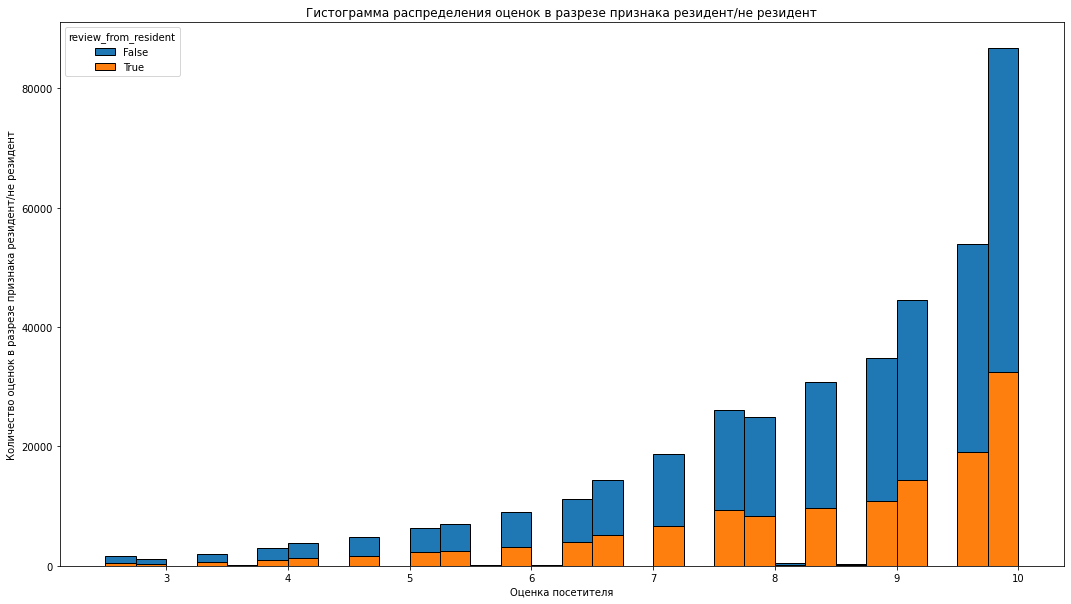

In [127]:
show_reviewer_score_histplot(
        data_hotels, 
        'review_from_resident', 
        'Гистограмма распределения оценок в разрезе признака резидент/не резидент', 
        'Количество оценок в разрезе признака резидент/не резидент',
    )

На первый взгляд кажется, что зависимости нет. \
Количество резидентов и не резидентов распределяется примерно одинаково.

## 8.5. Создание признака distance_from_city_center <a id="item_8_5"></a>

In [128]:
# создадим словарь с центрами городов
city_centers = {
    'London': (51.507222, -0.1275),
    'Paris': (48.833333, 2.333333),
    'Amsterdam': (52.383333, 4.9),
    'Milan': (45.466667, 9.166667),
    'Vienna': (48.216667, 16.373333),
    'Barcelona': (41.383333, 2.183333),
}

# возвращает расстояние от центра города до отеля в километрах
def get_distance_from_city_center(city, lat, lng):
    city_center = city_centers[city]
    hotel_center = (lat, lng)
    return round(GD(city_center, hotel_center).km, 1)

# заполним столбец данными
data_hotels['distance_from_city_center'] =\
    data_hotels.apply(lambda x: get_distance_from_city_center(x['hotel_city'], x['lat'], x['lng']), axis=1)
    
# добавим описание столбца в список
columns.update({'distance_from_city_center': 'расстояние до центра города в километрах'})

Посмотрим на распределение нового признака.

In [129]:
data_hotels['distance_from_city_center'].describe()

count    515431.000000
mean          3.509322
std           2.728083
min           0.100000
25%           1.700000
50%           3.200000
75%           4.400000
max          81.900000
Name: distance_from_city_center, dtype: float64

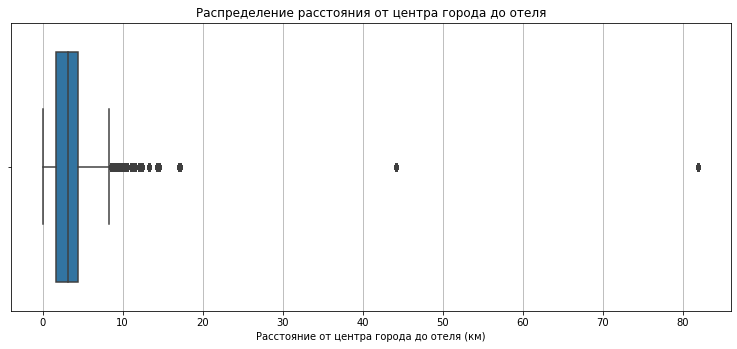

In [130]:
show_boxplot(
        data_hotels, 
        'distance_from_city_center', 
        'Распределение расстояния от центра города до отеля', 
        'Расстояние от центра города до отеля (км)'
    )

Распределение не является нормальным.

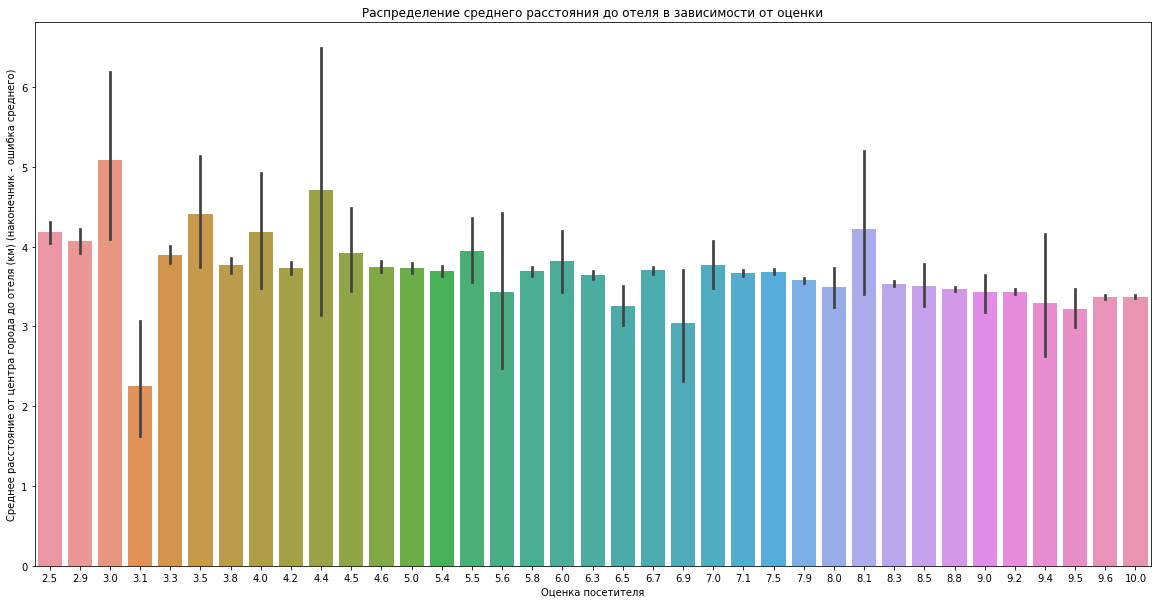

In [131]:
show_reviewer_score_barplot(
        data_hotels, 
        'distance_from_city_center', 
        'Распределение среднего расстояния до отеля в зависимости от оценки', 
        'Среднее расстояние от центра города до отеля (км)'
    )

Линейной зависимости не наблюдается.\
Но значения все же разные для разных оценок. \
Можно сделать предположение, что зависимость все же есть.

## 8.6. Создание признаков из столбца tags <a id="item_8_6"></a>

In [132]:
print_column_descriptions(data_hotels, ['tags'])

Признак : Тип........... : Описание

tags... : object........ : теги, которые рецензент дал отелю


Посмотрим на общее количество уникальных тегов.

In [133]:
# Множество тегов
tags_set = set()

# Пройдем по всем строкам
for tags in data_hotels['tags']:
    # Сформируем список из строки с тегами
    tags_list = ast.literal_eval(tags)
    # Добавим список во множество
    tags_set.update(tags_list)

len(tags_set)

2428

Посмотрим, какие теги более популярны.

In [134]:
# Список со всеми встречающимися тегами (с повторениями)
all_tags_list = []

# Пройдем по всем строкам
for tags in data_hotels['tags']:
    # Сформируем список из строки с тегами
    tags_list = ast.literal_eval(tags)
    # Добавим теги в общий список
    all_tags_list.extend(tags_list)

# Определим количество по каждому тегу
all_tags_counter = Counter(all_tags_list)

In [135]:
# Посмотрим 30 наиболее популярных значений
all_tags_counter.most_common()[0:30]

[(' Leisure trip ', 417538),
 (' Submitted from a mobile device ', 307470),
 (' Couple ', 252128),
 (' Stayed 1 night ', 193568),
 (' Stayed 2 nights ', 133850),
 (' Solo traveler ', 108476),
 (' Stayed 3 nights ', 95761),
 (' Business trip ', 82884),
 (' Group ', 65361),
 (' Family with young children ', 60989),
 (' Stayed 4 nights ', 47777),
 (' Double Room ', 35207),
 (' Standard Double Room ', 32247),
 (' Superior Double Room ', 31361),
 (' Family with older children ', 26334),
 (' Deluxe Double Room ', 24812),
 (' Double or Twin Room ', 22393),
 (' Stayed 5 nights ', 20826),
 (' Standard Double or Twin Room ', 17479),
 (' Classic Double Room ', 16877),
 (' Superior Double or Twin Room ', 13570),
 (' 2 rooms ', 12384),
 (' Stayed 6 nights ', 9765),
 (' Standard Twin Room ', 9745),
 (' Single Room ', 9668),
 (' Twin Room ', 8320),
 (' Stayed 7 nights ', 7391),
 (' Executive Double Room ', 6425),
 (' Classic Double or Twin Room ', 6100),
 (' Superior Twin Room ', 6054)]

In [136]:
# Функции для дальнейшего использования

def get_tag_with_subscripting(tags, subscripting):
    """Возвращает тег, который содержит подстроку subscripting
    Args:
        tags (str): строка с тегами из столбца tags
        subscripting (str): подстрока, для которой нужно найти тег
    Returns:
        str: тег, включающий подстрку subscripting
    """
    # Создаем список из строкового представления
    tags_list = ast.literal_eval(tags)
    # Обходим список и возвращаем нужные тег (если он есть)
    for tag in tags_list:
        if subscripting in tag:
            return tag
    return None


def get_tags_with_substring(substring):
    """Возвращает отсортированный список кортежей вида
    (тег включающий подстроку substring, общее количество использований)
    список отсортирован по количеству использований
    Args:
        substring (str): подстрока, на вхождение которой проверяем теги
    Return:
        list - список кортежей вида (тег включающий подстроку substring, общее количество использований)
    """
    # определяет, включает или не включает переданный тег подстроку substring
    def filter_substring(tag):
        if (substring in tag):
            return True
        return False
    
    # отфильтровываем из общего списка только те теги, которые включают подстроку substring
    tags_with_substring = filter(filter_substring, all_tags_list)
    
    # Counter подсчитывает количество вхождений тегов в общий список,
    # most_common сортирует в порядке популярности
    return Counter(tags_with_substring).most_common()

Популярны теги с типом путешествия "Leisure trip", "Business trip".\
Посмотрим, какие есть еще теги с "trip".

In [137]:
get_tags_with_substring('trip')

[(' Leisure trip ', 417538), (' Business trip ', 82884)]

Всего два варианта.\
Создадим признак **trip_type** с типом путешествия.

### Создание признака trip_type

In [138]:
# возвращает тип путешествия
def get_trip_type(tags):
    if ('Leisure trip' in tags and 'Business trip' in tags):
        return 'Leisure and Business'
    elif ('Leisure trip' in tags):
        return 'Leisure'
    elif ('Business trip' in tags):
        return 'Business'
    return 'Unknown'

# заполлним столбец значениями
data_hotels['trip_type'] = data_hotels['tags'].apply(get_trip_type)

# добавим описание признака в список
columns.update({'trip_type': 'Тип путешествия (Leisure|Business|Unknown)'})

Посмотрим на распределение нового признака.

In [139]:
data_hotels['trip_type'].value_counts()

Leisure     417538
Business     82884
Unknown      15009
Name: trip_type, dtype: int64

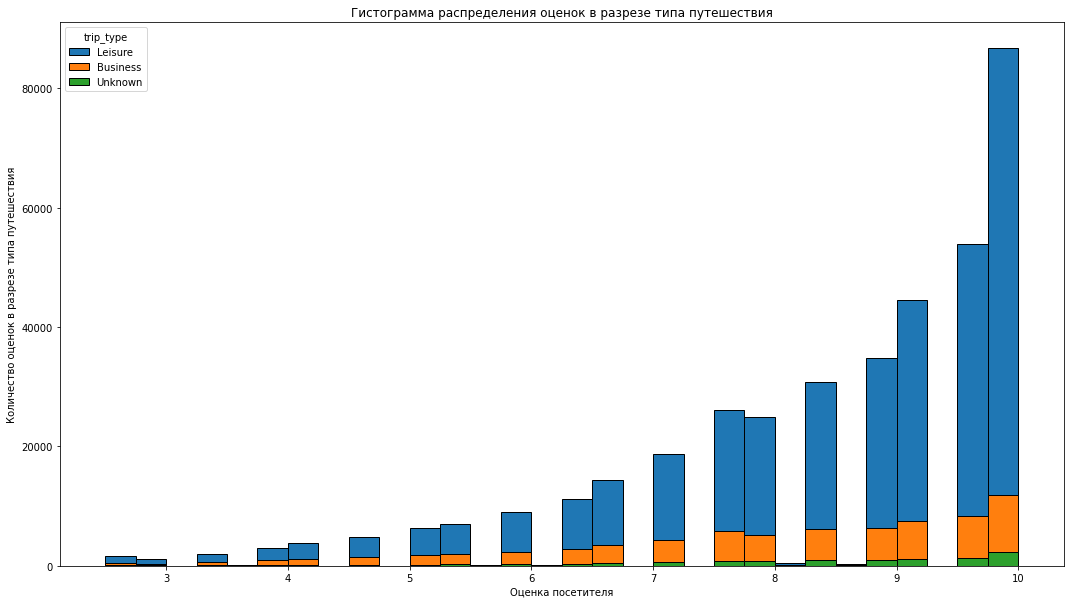

In [140]:
show_reviewer_score_histplot(
        data_hotels, 
        'trip_type', 
        'Гистограмма распределения оценок в разрезе типа путешествия', 
        'Количество оценок в разрезе типа путешествия',
    )

Визуально кажется, что зависимости нет и типы путешествий распределены примерно одинаково для всех оценок.

Популярен также тег "Submitted from a mobile device". \
Посмотрим, какие есть теги с включением значимых слов из тега.

In [141]:
get_tags_with_substring('Submitted')

[(' Submitted from a mobile device ', 307470)]

In [142]:
get_tags_with_substring('device')

[(' Submitted from a mobile device ', 307470)]

In [143]:
get_tags_with_substring('mobile')

[(' Submitted from a mobile device ', 307470)]

Таким образом, мы можем сделать признак "review_from_mobile".

### Создание признака review_from_mobile

In [144]:
# возвращает флаг наличия тега "Submitted from a mobile device"
def is_review_from_mobile(tags):
    if ('Submitted from a mobile device' in tags):
        return True
    return False

# заполним столбец значениями
data_hotels['review_from_mobile'] = data_hotels['tags'].apply(is_review_from_mobile)

# добавим описание признака в список
columns.update({'review_from_mobile': 'отправлен ли отзыв с мобильного устройства'})

Посмотрим на распределение нового признака.

In [145]:
data_hotels['review_from_mobile'].value_counts()

True     307470
False    207961
Name: review_from_mobile, dtype: int64

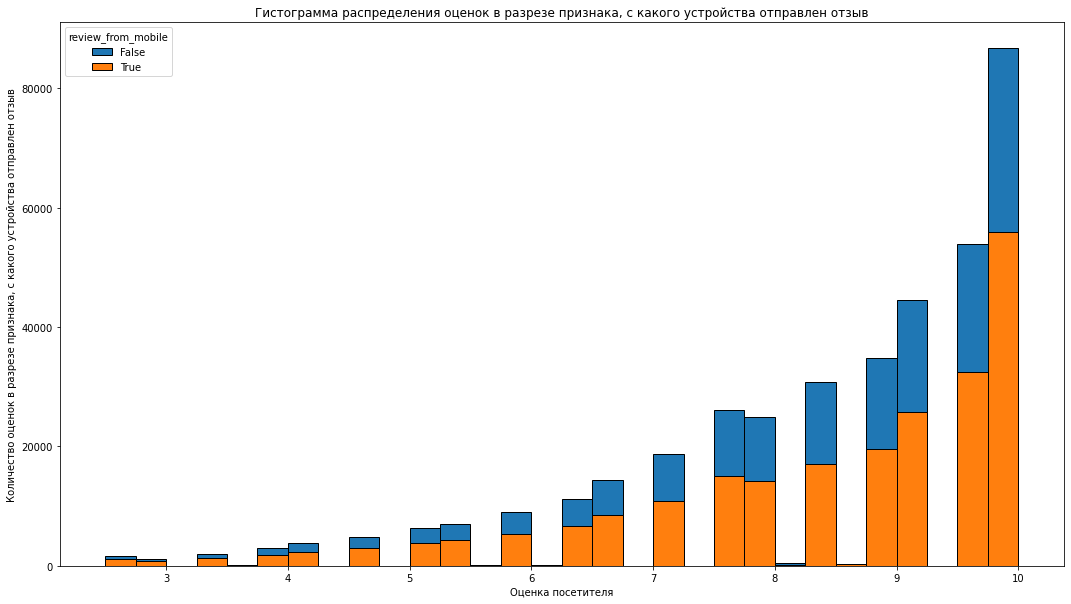

In [146]:
show_reviewer_score_histplot(
        data_hotels, 
        'review_from_mobile', 
        'Гистограмма распределения оценок в разрезе признака, с какого устройства отправлен отзыв', 
        'Количество оценок в разрезе признака, с какого устройства отправлен отзыв'
    )

Кажется, что зависимости нет.\
Распределение по признаку выглядит пропорциональным для разных оценок.

Также есть теги, которые говорят о том, сколько человек было в поездке:
- Couple - пара
- Solo traveler - индивидуальный путешественник
- Group - группа
- Family with young children - семья с маленькими детьми
- Family with older children - семья со старшими детьми
- Travelers with friends - путешествие с друзьями

Добавим признак **visitor_type** с указанием типа посетителя

### Создание признака visitor_type

In [147]:
# теги, которые говорят о типе посетителей
visitor_types = ['Couple', 'Solo traveler', 'Group', 'Family with young children', 
                 'Family with older children', 'Travelers with friends']

# возвращает либо тег из visitor_types, если он встречается в столбце, либо 'Unknown'
def get_visitor_type(tags):
    for type in visitor_types:
        if (type in tags):
            return type
    return 'Unknown'

# заполним столбец значениями
data_hotels['visitor_type'] = data_hotels['tags'].apply(get_visitor_type)

# добавим описание признака в словарь
columns.update({'visitor_type': 'тип посетителя'})

Посмотрим на распределение нового признака.

In [148]:
data_hotels['visitor_type'].value_counts()

Couple                        252128
Solo traveler                 108476
Group                          65361
Family with young children     60989
Family with older children     26334
Travelers with friends          2143
Name: visitor_type, dtype: int64

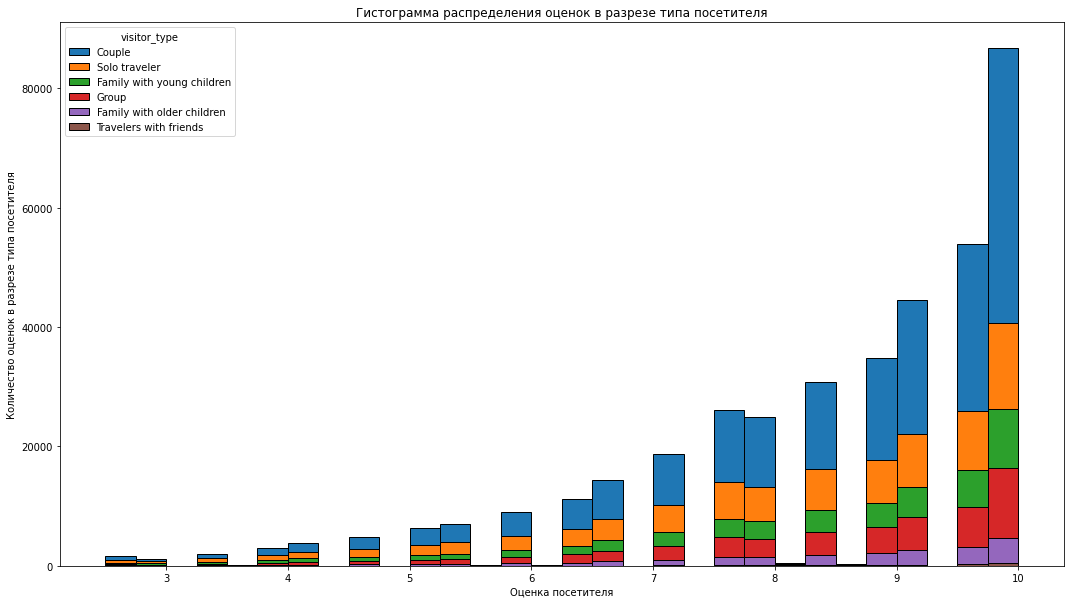

In [149]:
show_reviewer_score_histplot(
        data_hotels, 
        'visitor_type', 
        'Гистограмма распределения оценок в разрезе типа посетителя', 
        'Количество оценок в разрезе типа посетителя',
    )

На первый взгляд создается впечатление, что зависимость есть.\
Посетители с типом Couple чаще ставят хорошую оценку.

Есть также теги "Stayed 1 night", "Stayed 2 nights".\
Посмотрим, какие есть теги с вхождением "Stayed".

In [150]:
get_tags_with_substring('Stayed')

[(' Stayed 1 night ', 193568),
 (' Stayed 2 nights ', 133850),
 (' Stayed 3 nights ', 95761),
 (' Stayed 4 nights ', 47777),
 (' Stayed 5 nights ', 20826),
 (' Stayed 6 nights ', 9765),
 (' Stayed 7 nights ', 7391),
 (' Stayed 8 nights ', 2499),
 (' Stayed 9 nights ', 1293),
 (' Stayed 10 nights ', 888),
 (' Stayed 11 nights ', 417),
 (' Stayed 12 nights ', 316),
 (' Stayed 14 nights ', 247),
 (' Stayed 13 nights ', 246),
 (' Stayed 15 nights ', 117),
 (' Stayed 16 nights ', 57),
 (' Stayed 17 nights ', 42),
 (' Stayed 18 nights ', 33),
 (' Stayed 19 nights ', 29),
 (' Stayed 21 nights ', 23),
 (' Stayed 20 nights ', 19),
 (' Stayed 27 nights ', 11),
 (' Stayed 30 nights ', 11),
 (' Stayed 22 nights ', 10),
 (' Stayed 23 nights ', 10),
 (' Stayed 26 nights ', 7),
 (' Stayed 28 nights ', 7),
 (' Stayed 25 nights ', 7),
 (' Stayed 24 nights ', 6),
 (' Stayed 29 nights ', 5),
 (' Stayed 31 nights ', 1)]

Можно сделать признак **nights_count**, на сколько ночей останавливались посетители.

### Создание признака nights_count

In [151]:
# Возвращает из тега количество ночей, проведенных в отеле
def get_nights_count(tags):
    if ('Stayed' in tags):
        count = tags[tags.find('Stayed')+len('Stayed'):].split()[0]
        return int(count)

# заполним столбец значениями
data_hotels['nights_count'] = data_hotels['tags'].apply(get_nights_count)

In [154]:
# значения, где не смогли узнать количество ночей, заполним средним
data_hotels['nights_count'] = data_hotels['nights_count'].fillna(data_hotels['nights_count'].mean())

In [156]:
# добавим в словарь описание признака
columns.update({'nights_count': 'количество ночей, на которое бронировали отель'})

Посмотрим на распределение нового признака.

In [157]:
data_hotels['nights_count'].value_counts()

1.000000     193568
2.000000     133850
3.000000      95761
4.000000      47777
5.000000      20826
6.000000       9765
7.000000       7391
8.000000       2499
9.000000       1293
10.000000       888
11.000000       417
12.000000       316
14.000000       247
13.000000       246
2.362009        192
15.000000       117
16.000000        57
17.000000        42
18.000000        33
19.000000        29
21.000000        23
20.000000        19
30.000000        11
27.000000        11
22.000000        10
23.000000        10
28.000000         7
26.000000         7
25.000000         7
24.000000         6
29.000000         5
31.000000         1
Name: nights_count, dtype: int64

Чаще всего отель бронировали на одну ночь.

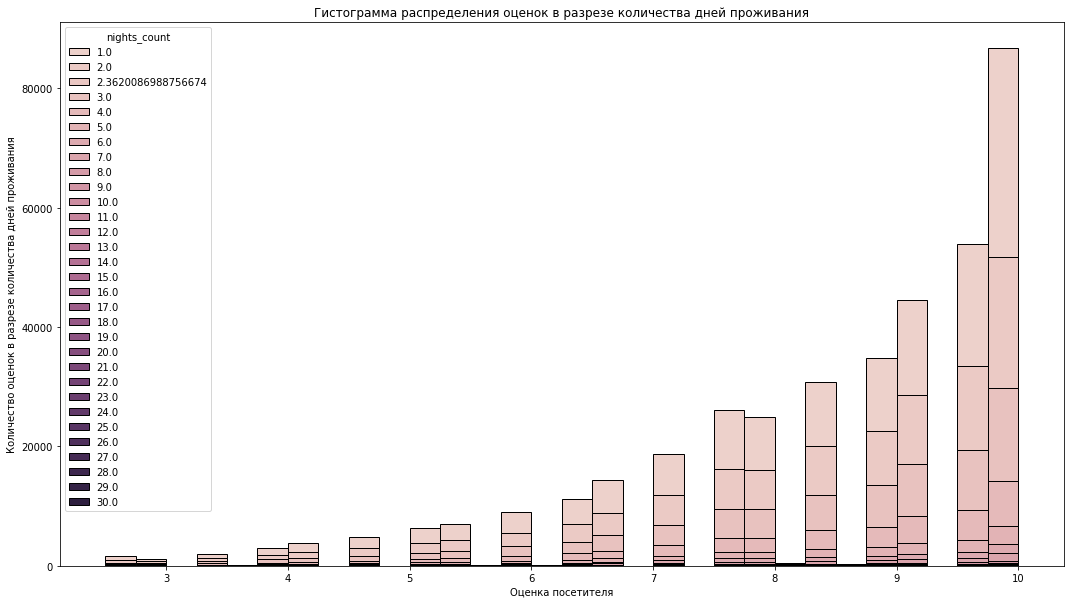

In [158]:
show_reviewer_score_histplot(
        data_hotels, 
        'nights_count', 
        'Гистограмма распределения оценок в разрезе количества дней проживания', 
        'Количество оценок в разрезе количества дней проживания',
    )

Однозначной зависимости по графику не видно.

Также есть довольно много тегов с включением "Room".\
В которых обозначено, какой тип помещения снимали жильцы.\
Посмотрим на них.

In [159]:
get_tags_with_substring('Room')[0:10]

[(' Double Room ', 35207),
 (' Standard Double Room ', 32247),
 (' Superior Double Room ', 31361),
 (' Deluxe Double Room ', 24812),
 (' Double or Twin Room ', 22393),
 (' Standard Double or Twin Room ', 17479),
 (' Classic Double Room ', 16877),
 (' Superior Double or Twin Room ', 13570),
 (' Standard Twin Room ', 9745),
 (' Single Room ', 9668)]

In [160]:
get_tags_with_substring('room')[0:10]

[(' 2 rooms ', 12384),
 (' Double Hilton Guestroom ', 1300),
 (' One Bedroom Suite ', 661),
 (' 3 rooms ', 474),
 (' One Bedroom Apartment ', 358),
 (' Deluxe One Bedroom Apartment ', 348),
 (' Two Bedroom Apartment ', 180),
 (' Deluxe One Bedroom Suite ', 133),
 (' Compact Double Room with Private Bathroom ', 128),
 (' Queen Guestroom ', 112)]

Попробуем выделить из этих данных уровень качества комнат.

### Создание признака room_level

In [161]:
# Выделим в список слова, которые говорят об уровне сервиса
levels = ['Classic', 'Deluxe', 'Basic', 'Comfort', 'Standard', 'Superior', 'Cosy', 'Economy', 
          'Executive', 'Luxury', 'Premier', 'Compact', 'Premium', 'Budget', 'Privilege']

# возвращает теги с вхождением слова "Room"
def get_tag_with_room(tags):
    tag_with_room = get_tag_with_subscripting(tags, 'Room')
    if (not tag_with_room):
        tag_with_room = get_tag_with_subscripting(tags, 'room')
    return tag_with_room


# если тег со словом "Room" содержит слово из levels, вернется это слово
def get_room_level(tags):
    tag_with_room = get_tag_with_room(tags)
    
    if (tag_with_room):
        for level in levels:
            if (level in tag_with_room):
                return level
    return 'Unknown'


# заполним столбец значениями
data_hotels['room_level'] = data_hotels['tags'].apply(get_room_level)

# добавим описание признака в словарь
columns.update({'room_level': 'Уровень сервиса помещения'})

Посмотрим на распределение нового признака.

In [162]:
data_hotels['room_level'].value_counts()

Unknown      209043
Standard      84810
Superior      83288
Deluxe        61953
Classic       35505
Executive     17852
Comfort        7748
Basic          3221
Cosy           2252
Luxury         2173
Premier        1887
Premium        1746
Economy        1659
Privilege      1065
Compact        1053
Budget          176
Name: room_level, dtype: int64

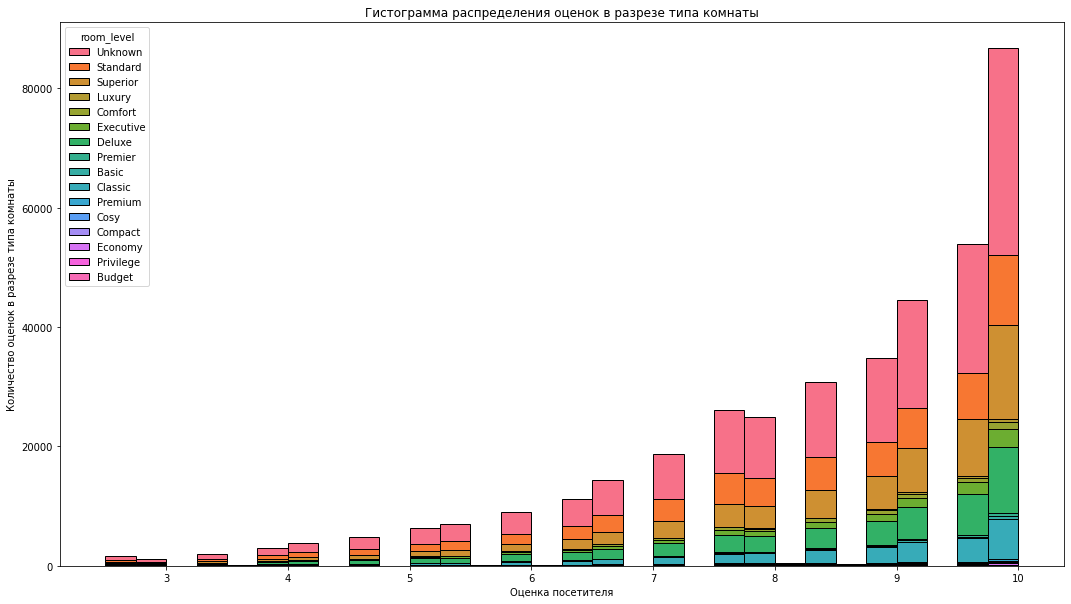

In [163]:
show_reviewer_score_histplot(
        data_hotels, 
        'room_level', 
        'Гистограмма распределения оценок в разрезе типа комнаты', 
        'Количество оценок в разрезе типа комнаты'
    )

На первый взгляд зависимости не наблюдается.

В теге с включением "room" также встречаютя слова Queen и King.\
Их наличие говорит о том, что в номере есть кровать большого размера.\
Создадим на их основе признак **is_big_bed**.

### Создание признака is_big_bed

In [164]:
# названия большой кровати
big_bed_names = ['queen', 'king']

# определяет, есть ли упоминание большой кровати в тегах
def is_big_bed(tags):
    tag_with_room = get_tag_with_room(tags)
    
    if (tag_with_room):
        for bed_name in big_bed_names:
            if (bed_name in tag_with_room.lower()):
                return True
    return False

# заполним столбец значениями
data_hotels['is_big_bed'] = data_hotels['tags'].apply(is_big_bed)

# добавим описание признака в словарь
columns.update({'is_big_bed': 'наличие в номере большой кровати'})

Посмотрим на распределение нового признака.

In [165]:
data_hotels['is_big_bed'].value_counts()

False    447847
True      67584
Name: is_big_bed, dtype: int64

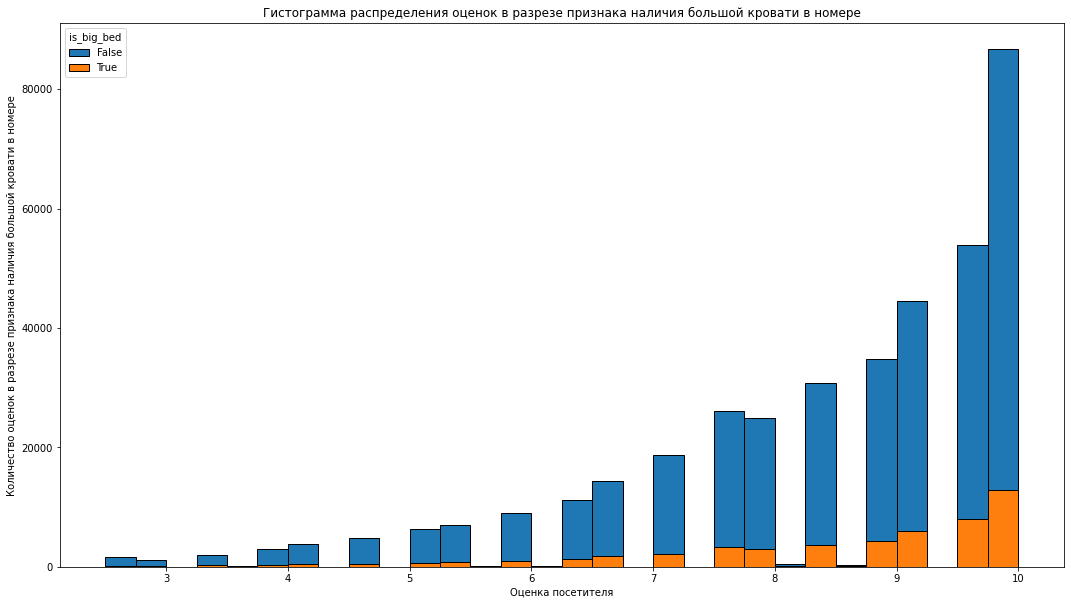

In [166]:
show_reviewer_score_histplot(
        data_hotels, 
        'is_big_bed', 
        'Гистограмма распределения оценок в разрезе признака наличия большой кровати в номере', 
        'Количество оценок в разрезе признака наличия большой кровати в номере',
    )

На первый взгляд создаетя впечатления, что зависимости нет.

Также в описании комнат иногда встречается слово View.\
И это говорит о том, что есть вид из окна, о котором стоит упомянуть.

### Создание признака is_room_with_view

In [167]:
# возвращает флаг, есть ли слово "view" в теге со словом "room"
def is_room_with_view(tags):
    # тег со словом "room"
    tag_with_room = get_tag_with_room(tags)
    
    # если тег со словом "room" есть
    if (tag_with_room):
        # и в нем упоминается "view" и не указано, что комната без вида "No view"
        if ('view' in tag_with_room.lower() and 'No view' not in tag_with_room):
            return True
    
    return False

# заполним столбец значениями
data_hotels['is_room_with_view'] = data_hotels['tags'].apply(is_room_with_view)

# запомним описание признака
columns.update({'is_room_with_view': 'номер с видом из окна'})

Посмотрим на распределение нового признака.

In [168]:
data_hotels['is_room_with_view'].value_counts()

False    499234
True      16197
Name: is_room_with_view, dtype: int64

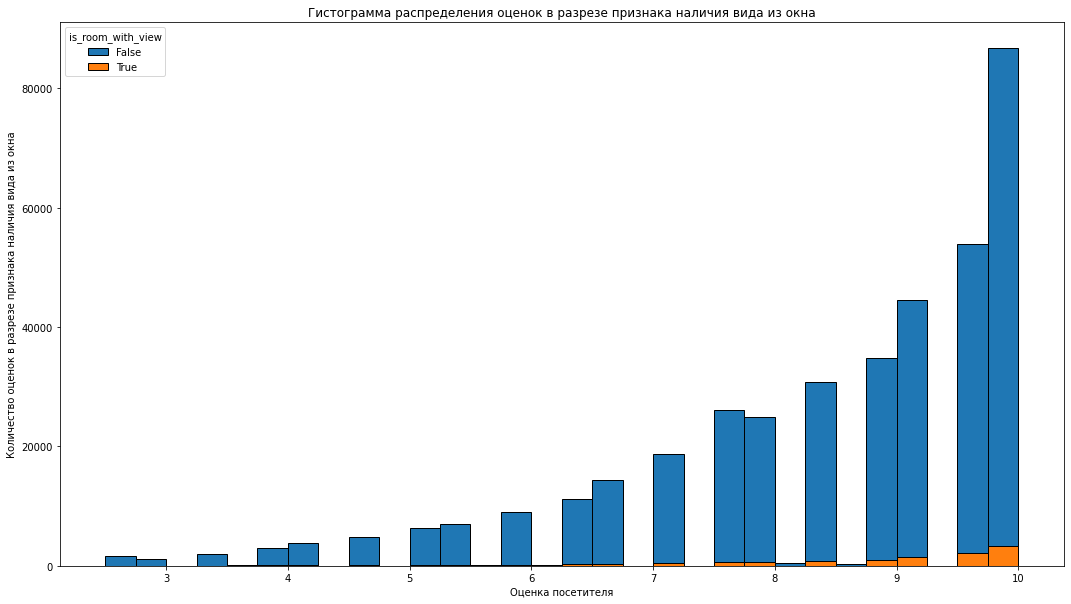

In [169]:
show_reviewer_score_histplot(
        data_hotels, 
        'is_room_with_view', 
        'Гистограмма распределения оценок в разрезе признака наличия вида из окна', 
        'Количество оценок в разрезе признака наличия вида из окна',
    )

На первый взгляд зависимости не наблюдается.

### Создание признака tags_count

In [170]:
# возвращает количество указанных в столбце tags тегов
def get_tags_count(tags):
    tags_list = ast.literal_eval(tags)
    return len(tags_list)

# заполним столбец значениями
data_hotels['tags_count'] = data_hotels['tags'].apply(get_tags_count)

# добавим описание столбца в список
columns.update({'tags_count': 'количество указанных тегов'})

Посмотрим на распределение нового признака.

In [171]:
data_hotels['tags_count'].value_counts()

5    297661
4    211423
3      5501
6       755
2        85
1         6
Name: tags_count, dtype: int64

Чаще всего указывают 4-5 тегов.

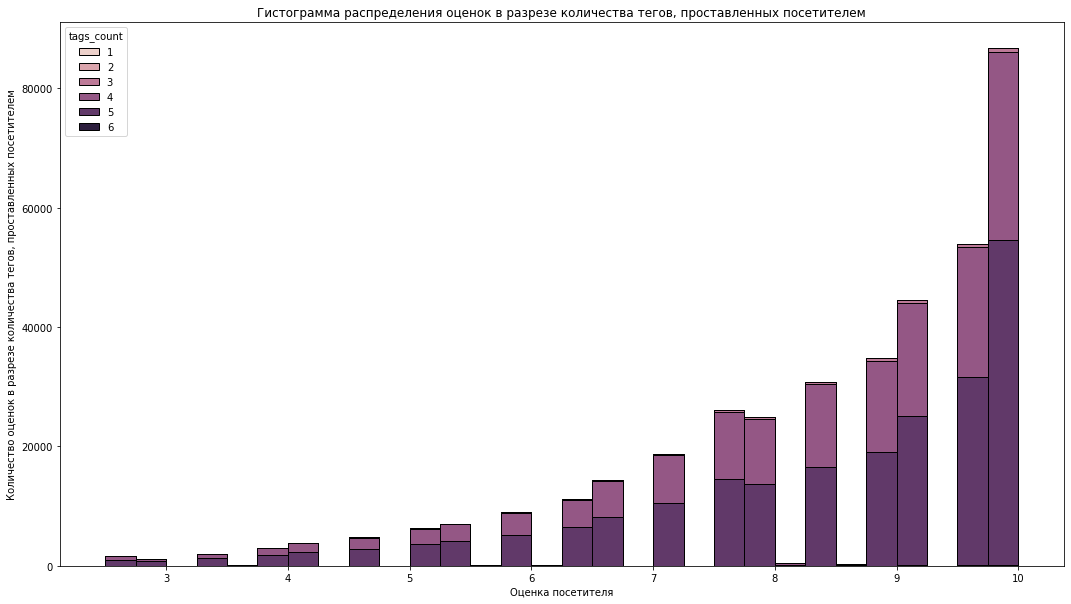

In [172]:
show_reviewer_score_histplot(
        data_hotels, 
        'tags_count', 
        'Гистограмма распределения оценок в разрезе количества тегов, проставленных посетителем', 
        'Количество оценок в разрезе количества тегов, проставленных посетителем',
    )

Кажется, что зависимости нет.\
Количество тегов для разных оценок примерно пропорционально.

## 8.7. Создание признаков из столбца review_date <a id="item_8_7"></a>

In [173]:
print_column_descriptions(data_hotels, ['review_date'])

Признак.... : Тип........... : Описание

review_date : datetime64[ns] : дата, когда рецензент разместил соответствующий отзыв


### Создание признака review_month

Создадим признак **review_month** с номером месяца, когда поставлена оценка.

In [174]:
data_hotels['review_month'] = data_hotels['review_date'].dt.month

# Добавим описание столбца в список
columns.update({'review_month': 'месяц, когда оставлен отзыв'})

Посмотрим, в каком месяце чаще оставляли отзывы.

In [175]:
data_hotels['review_month'].value_counts()

8     50632
7     49291
5     46470
10    43803
6     42877
4     42872
9     42369
1     42133
3     41090
12    39591
2     38352
11    35951
Name: review_month, dtype: int64

Чаще всего оставляли отзывы в августе.\
И реже всего в ноябре.

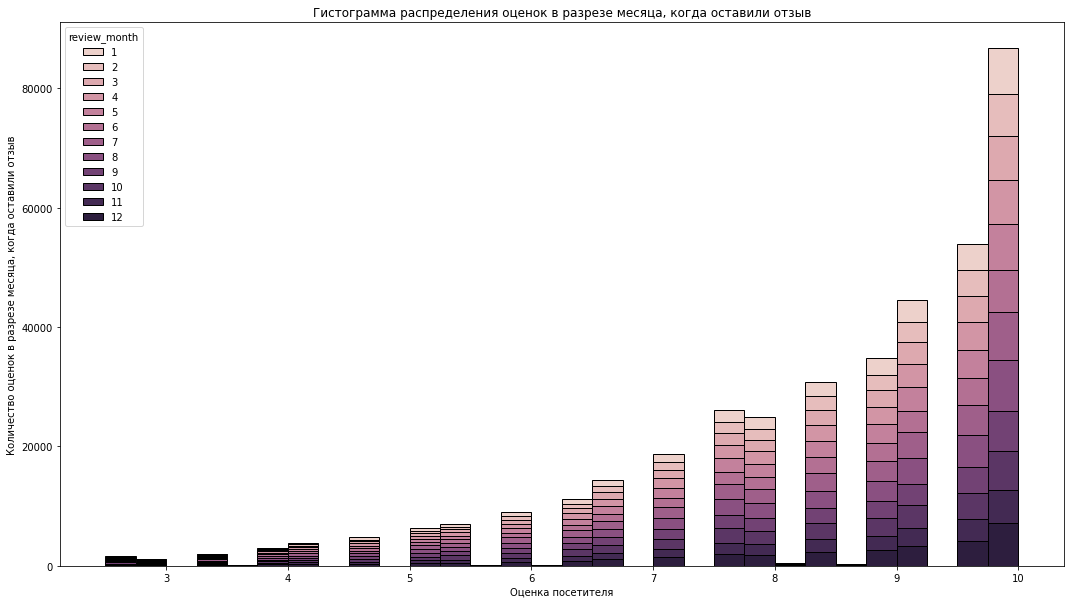

In [176]:
show_reviewer_score_histplot(
        data_hotels, 
        'review_month', 
        'Гистограмма распределения оценок в разрезе месяца, когда оставили отзыв', 
        'Количество оценок в разрезе месяца, когда оставили отзыв',
    )

На первый взгляд кажется, что зависимости нет.\
Значения распределены примерно пропорционально.

### Создание признака review_season

Создадим признак **review_season** со временем года, когда оставлен отзыв.

При этом учтем время начала и конца сезонов в Европе:
- весна длится с 21 марта до 21 июня, 
- лето с 22 июня до 22 сентября, 
- осень с 23 сентября до 21 декабря, 
- а зима с 22 декабря до 20 марта.

In [177]:
# определим границы времен года
seasons_bounds = {
    'spring': { 'start': (3, 21), 'end': (6, 21) },
    'summer': { 'start': (6, 22), 'end': (9, 22) },
    'autumn': { 'start': (9, 23), 'end': (12, 21) },
    'winter': { 'start': (12, 22), 'end': (3, 20) },
}
# запомним время начала зимы
winter_start = seasons_bounds['winter']['start']

# возвращает, какому времени года принадлежит переданная дата
def get_season(date):
    year = date.year
    month = date.month
    day = date.day
    
    for season_name, dates_interval in seasons_bounds.items():
        start = dates_interval['start']
        end = dates_interval['end']
        
        year_start = year
        year_end = year
        if (season_name == 'winter'):
            if (month == winter_start[0] and day >= winter_start[1]):
                year_end = year + 1
            else:
                year_start = year - 1
        
        date_start = datetime.datetime(year_start, start[0], start[1])
        date_end = datetime.datetime(year_end, end[0], end[1])
        
        if (date >= date_start and date <= date_end):
            return season_name

# заполним столбец значениями
data_hotels['review_season'] = data_hotels['review_date'].apply(get_season)

# добавим описание столбца в список
columns.update({'review_season': 'время года, когда оставлен отзыв'})

Посмотрим, в какое время года чаще оставляли отзывы.

In [178]:
data_hotels['review_season'].value_counts()

summer    144099
spring    133042
autumn    119177
winter    119113
Name: review_season, dtype: int64

Примерно одинаково, но чаще летом.

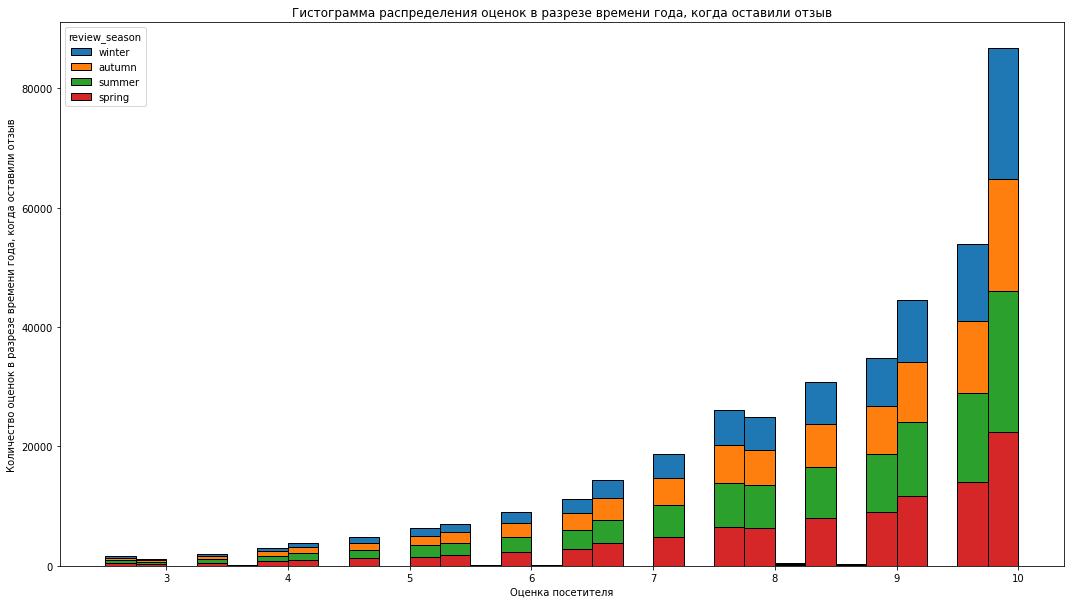

In [179]:
show_reviewer_score_histplot(
        data_hotels, 
        'review_season', 
        'Гистограмма распределения оценок в разрезе времени года, когда оставили отзыв', 
        'Количество оценок в разрезе времени года, когда оставили отзыв',
    )

На первый взгляд зависимости нет.

### Создание признака review_day

Создадим признак **review_day** с номером дня месяца, когда оставили отзыв.

In [180]:
data_hotels['review_day'] = data_hotels['review_date'].dt.day

# Добавим описание столбца в список
columns.update({'review_day': 'число месяца, когда оставлен отзыв'})

Посмотрим, в каких числах чаще оставляли отзывы.

In [181]:
data_hotels['review_day'].value_counts().head(5)

5     20225
3     19501
15    18330
10    18266
20    18109
Name: review_day, dtype: int64

Чаще всего отзывы оставляли 5 числа.

Вряд ли построение графика тут дас ценную информацию.\
Проверим потом ценность этого признака для модели вместе с другими.

### Создание признака review_month_day

Создадим признак из месяца и дня, когда оставлен отзыв.\
Возможно, значение признака будет совпадать с праздниками или другими годовщинами, от которых зависит лояльность посетителей.

In [182]:
# возвращает строку "месяц_день" для переданной даты
def get_month_day(date):
    month = date.month
    day = date.day
    return str(month) + '_' + str(day)

# заполним столбец значениями
data_hotels['review_month_day'] = data_hotels['review_date'].apply(get_month_day)

# запомним описание столбца
columns.update({'review_month_day': 'месяц и день отзыва'})

Посмотрим, в какие даты чаще оставляли отзывы.

In [183]:
data_hotels['review_month_day'].value_counts().head(5)

8_2     4366
4_5     3842
9_15    3644
5_3     3065
7_5     3005
Name: review_month_day, dtype: int64

Наибольшее количество отзывов оставили 2 августа.

# 9. Оценка влияния признаков на целевую переменную и удаление не актуальных признаков <a id="item_9"></a>

Вспомним, какие у нас есть признаки.

In [184]:
print_column_descriptions(data_hotels)

Признак................................... : Тип........... : Описание

hotel_address............................. : object........ : адрес отеля
additional_number_of_scoring.............. : int64......... : есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
review_date............................... : datetime64[ns] : дата, когда рецензент разместил соответствующий отзыв
average_score............................. : float64....... : средний балл отеля, рассчитанный на основе последнего комментария за последний год
hotel_name................................ : object........ : название отеля (с добавлением города для дублирующихся названий в разных гродах)
reviewer_nationality...................... : object........ : страна рецензента
negative_review........................... : object........ : отрицательный отзыв, который рецензент дал отелю
review_total_negative_word_counts....

Удалим столбцы, которые больше не нужны.

In [185]:
# Столбцы для удаления
columns_to_drop = ['hotel_address', 'review_date', 'negative_review', 'positive_review', 'tags',
                   'positive_scores', 'negative_scores', 'review_coefficient', 'hotel_country']

# Удалим столбцы
data_hotels.drop(columns_to_drop, axis=1, inplace=True)

# Удалим описания из словаря
delete_from_columns(columns_to_drop)

Выделим категориальные и числовые признаки.

In [186]:
# Числовые признаки
numerical_features = [
    'additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'total_positive_reviews',
    'total_negative_reviews',
    'negative_neg',
    'negative_neu',
    'negative_pos',
    'negative_compound',
    'positive_neg',
    'positive_neu',
    'positive_pos',
    'positive_compound',
    'total_positive_word_counts',
    'total_negative_word_counts',
    'total_positive_word_counts_mean',
    'total_positive_word_counts_median',
    'total_negative_word_counts_mean',
    'total_negative_word_counts_median',
    'review_positive_coefficient',
    'review_negative_coefficient',
    'review_positive_coefficient_mean',
    'review_positive_coefficient_median',
    'review_negative_coefficient_mean',
    'review_negative_coefficient_median',
    'distance_from_city_center',
]

# Категориальные признаки
categorical_features = [
    'hotel_name',
    'lat',
    'lng',
    'reviewer_nationality',
    'positive_review_language',
    'negative_review_language',
    'hotel_city',
    'postal_code',
    'review_from_resident',
    'trip_type',
    'review_from_mobile',
    'visitor_type',
    'nights_count',
    'room_level',
    'is_big_bed',
    'is_room_with_view',
    'tags_count',
    'review_month',
    'review_season',
    'review_day',
    'review_month_day',
]

Посмотрим на количество уникальных категориальных признаков.

In [187]:
data_hotels[categorical_features].nunique().sort_values(ascending=False)

hotel_name                  1494
lat                         1485
lng                         1485
review_month_day             366
postal_code                  240
reviewer_nationality         227
positive_review_language      53
negative_review_language      51
nights_count                  32
review_day                    31
room_level                    16
review_month                  12
visitor_type                   6
hotel_city                     6
tags_count                     6
review_season                  4
trip_type                      3
review_from_resident           2
is_big_bed                     2
is_room_with_view              2
review_from_mobile             2
dtype: int64

Вспомним, какие в них типы данных.

In [188]:
print_column_descriptions(data_hotels, categorical_features)

Признак................. : Тип........... : Описание

hotel_name.............. : object........ : название отеля (с добавлением города для дублирующихся названий в разных гродах)
lat..................... : float64....... : географическая широта отеля
lng..................... : float64....... : географическая долгота отеля
reviewer_nationality.... : object........ : страна рецензента
positive_review_language : object........ : язык позитивного отзыва
negative_review_language : object........ : язык негативного отзыва
hotel_city.............. : object........ : город отеля
postal_code............. : object........ : почтовый индекс отеля
review_from_resident.... : bool.......... : отзыв оставлен жителем страны, в которой находится отель
trip_type............... : object........ : Тип путешествия (Leisure|Business|Unknown)
review_from_mobile...... : bool.......... : отправлен ли отзыв с мобильного устройства
visitor_type............ : object........ : тип посетителя
nights_count..........

Создадим копию тренировочных данных таблицы **hotel_name** для кодирования признаков и проверки их значимости.

In [194]:
data_hotels_temp = get_train_data(data_hotels)

In [195]:
# Переведем признаки c типом object, а также lat и lng в категориальные
category_columns = ['hotel_name', 'lat', 'lng', 'reviewer_nationality', 
                    'positive_review_language', 'negative_review_language', 
                    'hotel_city', 'postal_code', 'review_from_resident', 
                    'trip_type', 'visitor_type', 'room_level', 
                    'review_season', 'review_month_day', 'nights_count']

for column_name in category_columns:
    data_hotels_temp[column_name] = data_hotels_temp[column_name].astype('category').cat.codes

Разделим датафрейм на части.

In [196]:
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = data_hotels_temp.drop(['reviewer_score'], axis=1)  
y = data_hotels_temp['reviewer_score'] 

Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат. \
Метод возвращает массив значений **хи-квадрат** и **p-value** для каждого признака. \
Используем только значения хи-квадрат и выведем их на графике:

<AxesSubplot:>

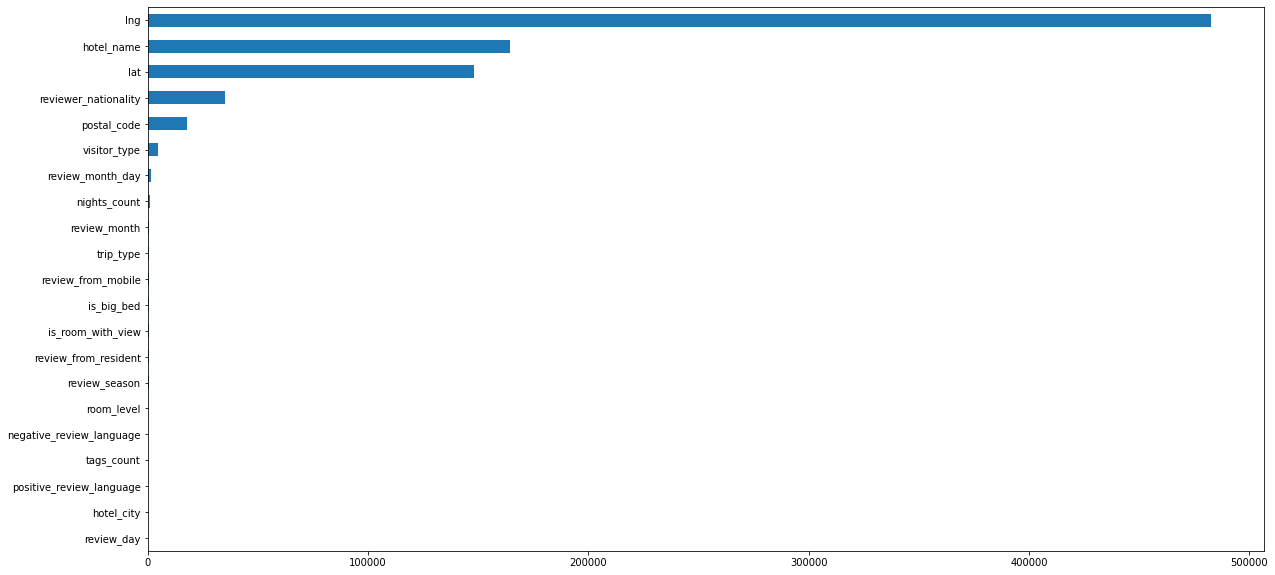

In [197]:
y = y.astype('int')

imp_cat = pd.Series(chi2(X[categorical_features], y)[0], index=categorical_features)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', figsize=(20, 10))

Удалим наименее значимые признаки.

In [198]:
# Столбцы для удаления
columns_to_drop = ['review_day', 'hotel_city', 'positive_review_language', 'tags_count',
                   'negative_review_language', 'room_level', 'review_season',
                   'review_from_resident', 'is_room_with_view', 'is_big_bed', 
                   'review_from_mobile', 'trip_type', 'review_month']
    
# Удалим столбцы
data_hotels_temp.drop(columns_to_drop, axis=1, inplace=True)
data_hotels.drop(columns_to_drop, axis=1, inplace=True)

# Удалим описания из словаря
delete_from_columns(columns_to_drop)

Для оценки значимости непрерывных переменных будем использовать функцию **f_classif** из библиотеки **sklearn**. \
В основе метода оценки значимости переменных лежит анализ (**ANOVA**). \
Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (**2-sample t**).

Метод возвращает двумерный массив **f-статистик** и **p-value** для каждого признака. \
В качестве меры значимости мы будем использовать значение **f-статистики**. \
Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, \
и тем важнее данный признак для модели.

<AxesSubplot:>

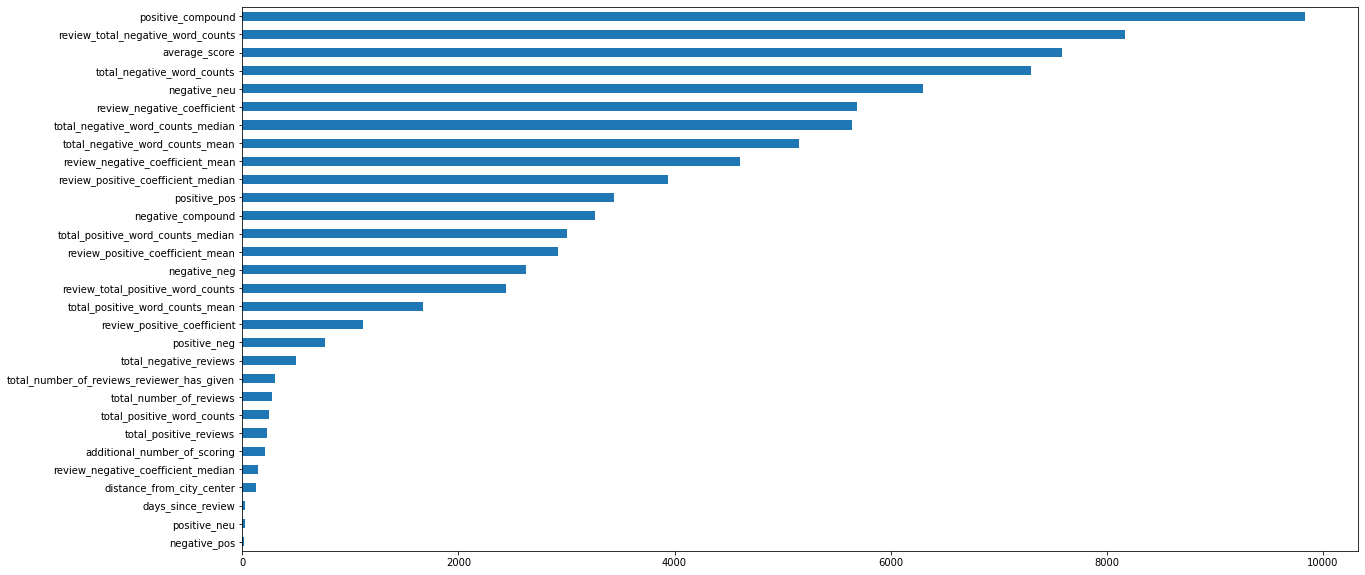

In [199]:
imp_num = pd.Series(f_classif(X[numerical_features], y)[0], index = numerical_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind='barh', figsize=(20, 10))

Все признаки имеют некоторое значение.\
Не будем ничего удалять.

Проверим, есть ли мультиколинеарные признаки.\
Построим матрицу кореляции.

Text(0.5, 1.0, 'Тепловая карта корелляции признаков')

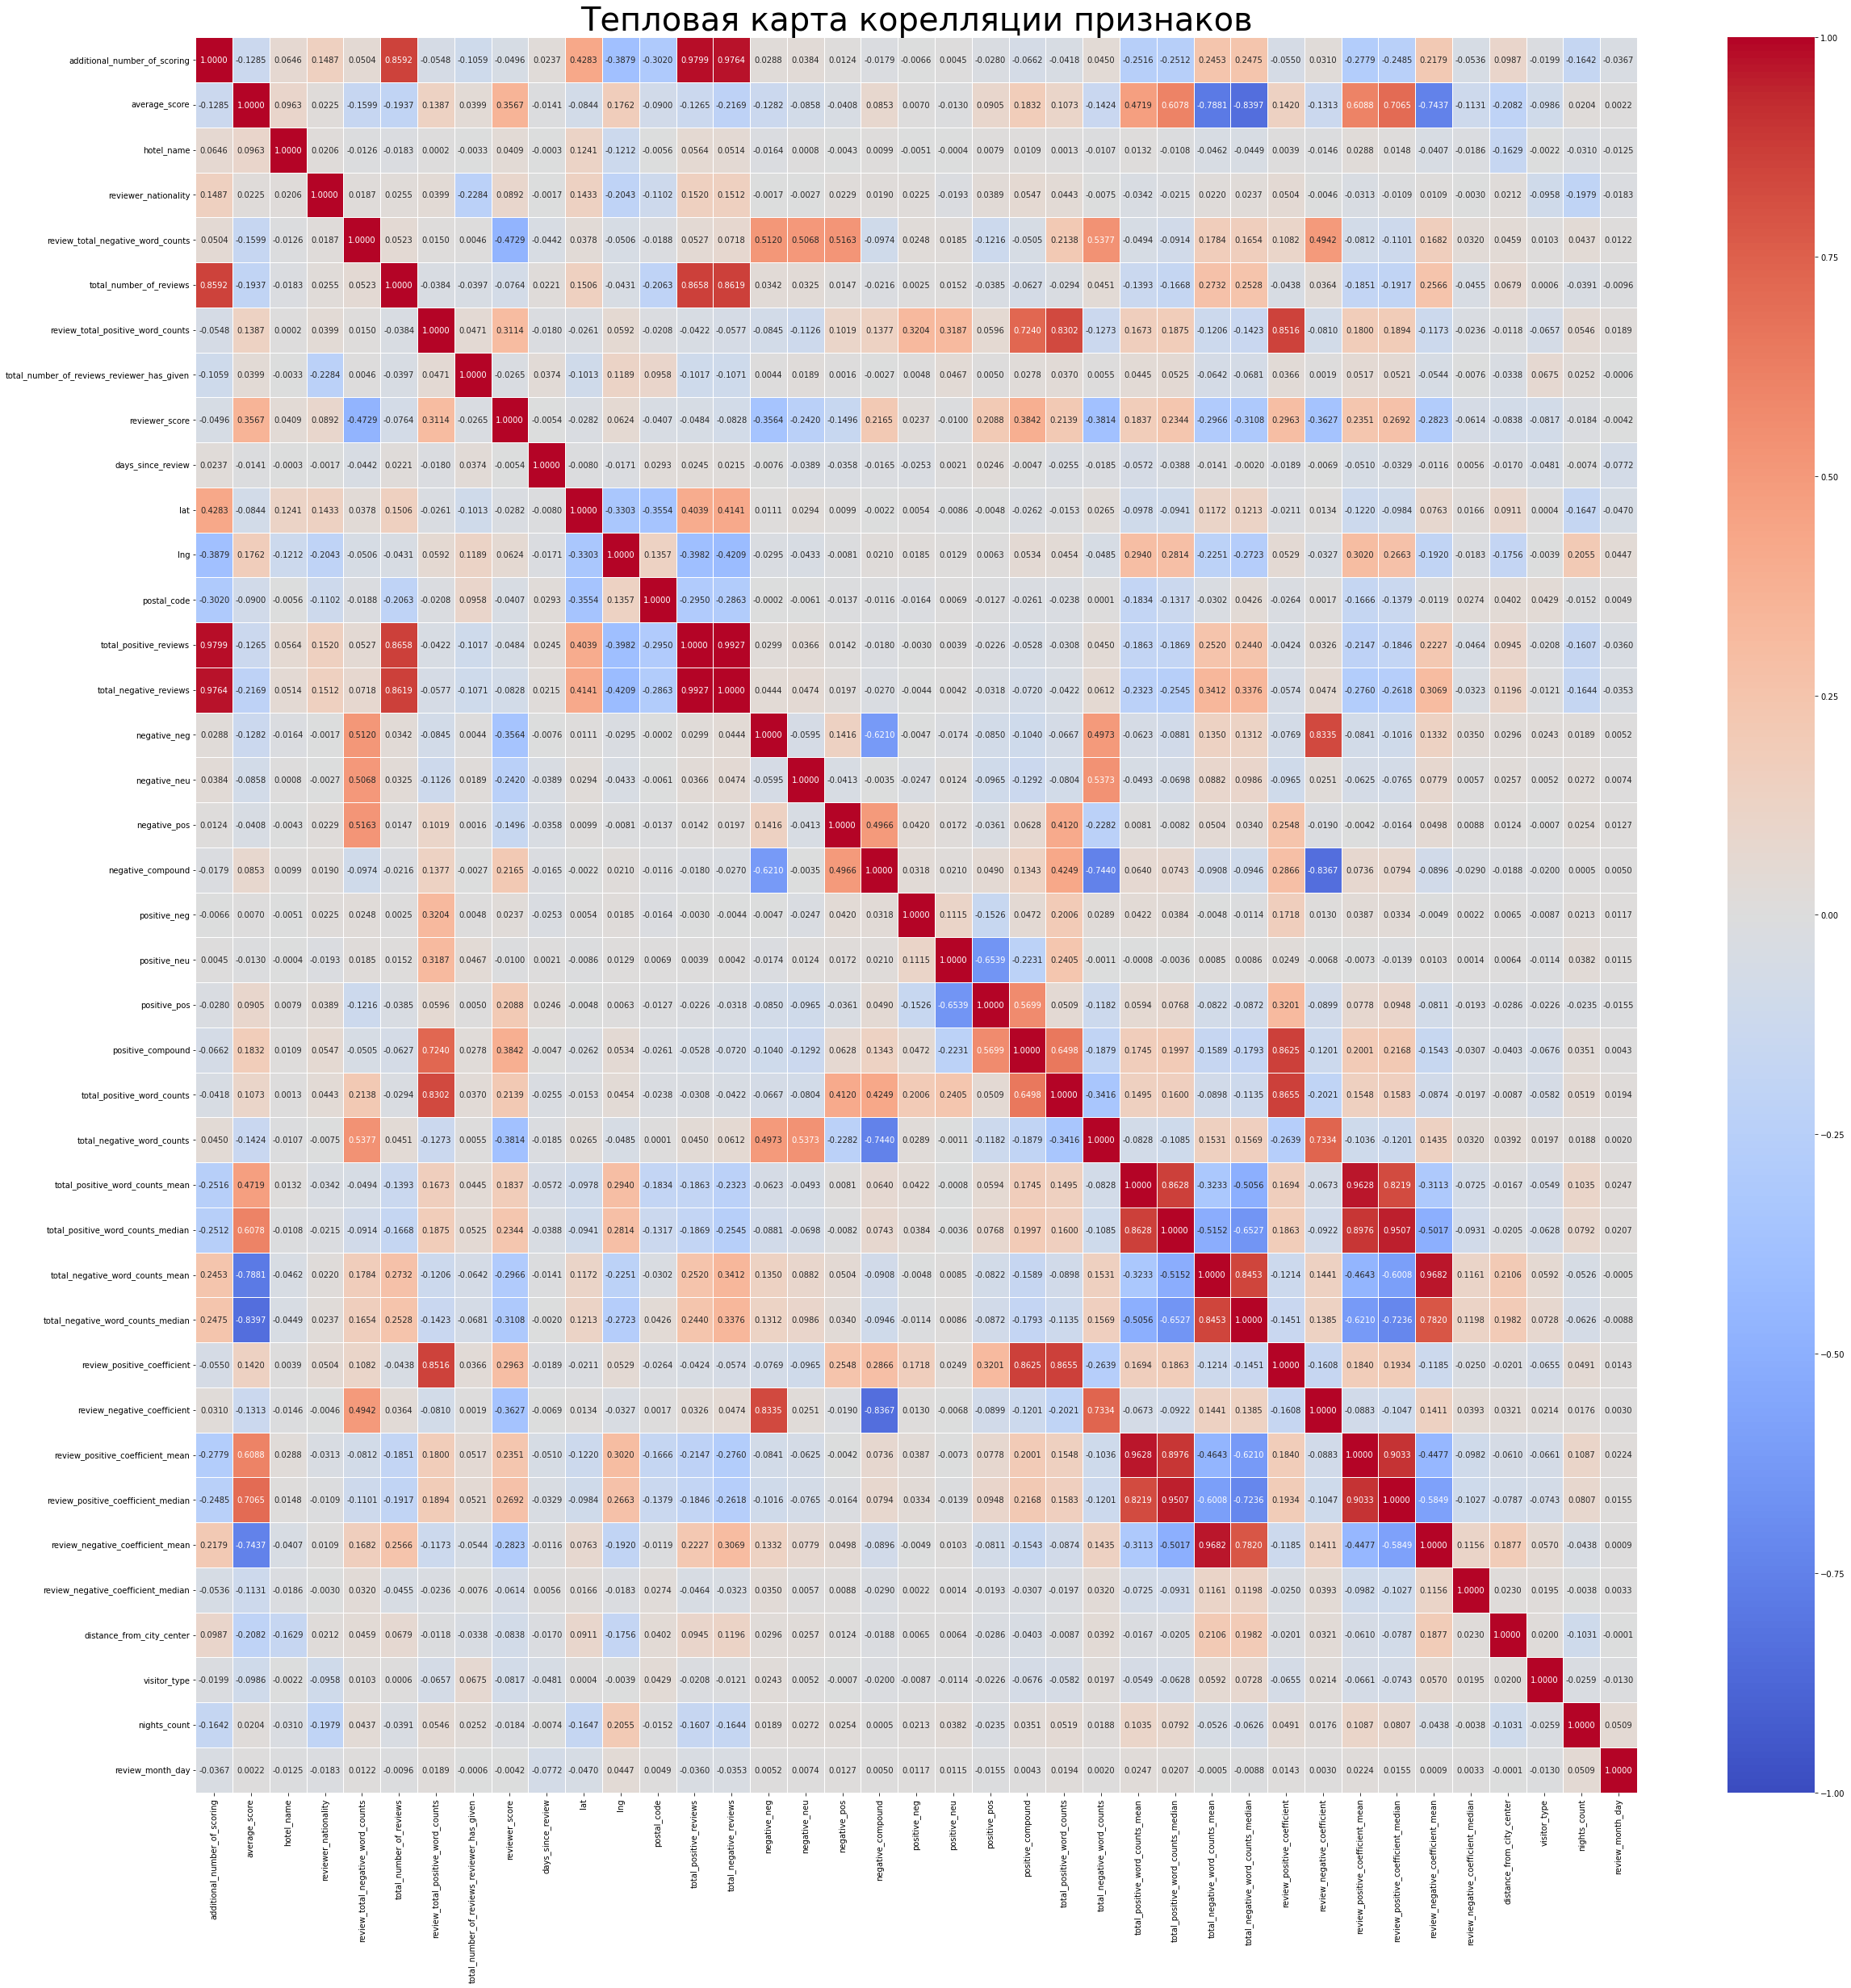

In [200]:
# посчитаем матрицу корелляции
data_hotels_corr = data_hotels_temp.corr(method='spearman')

# построим тепловую карту
fig, ax = plt.subplots(figsize=(40, 40))

# зададим параметры для тепловой карты
sns.heatmap(
    data_hotels_corr, annot=True, vmin=-1, vmax=1, center=0, linewidths=.9, ax=ax, fmt='.4f', cmap='coolwarm'
)
plt.title(
    'Тепловая карта корелляции признаков', 
    fontsize=40
)

Напишем функцию, которая вернет пары мультиколлинеарных признаков.

In [201]:
def get_multicolinear_pairs(df, corr_coeff):
    """Возвращает пары мультиколинеарных признаков и значение кореляции между ними.
    Args:
        df (Data Frame): таблица с данными
        corr_coeff (Number): коэффициент корелляции, выше которого отбираем пары
    Returns:
        List: Список с именами столбцов и коэффициентом корелляции
              ([столбец1, столбец2], коэффициент)
    """
    col_names = list(df.columns)
    
    colls_pairs = []
    
    for col1 in col_names:
        for col2 in col_names:
            if (col1 != col2 and [col1, col2] not in colls_pairs and [col2, col1] not in colls_pairs):
                colls_pairs.append([col1, col2])
    
    multicolinear_pairs = []
    
    for pair in colls_pairs:
        corr_between_colls = round(df.corr()[pair[0]][pair[1]], 2)
        if (abs(corr_between_colls) > abs(corr_coeff)):                    
            multicolinear_pairs.append((pair, corr_between_colls))
            
    return multicolinear_pairs

get_multicolinear_pairs(data_hotels_temp, 0.7)

[(['additional_number_of_scoring', 'total_number_of_reviews'], 0.82),
 (['additional_number_of_scoring', 'total_positive_reviews'], 0.98),
 (['additional_number_of_scoring', 'total_negative_reviews'], 0.97),
 (['average_score', 'total_negative_word_counts_mean'], -0.81),
 (['average_score', 'total_negative_word_counts_median'], -0.85),
 (['average_score', 'review_negative_coefficient_mean'], -0.76),
 (['total_number_of_reviews', 'total_positive_reviews'], 0.84),
 (['total_number_of_reviews', 'total_negative_reviews'], 0.82),
 (['review_total_positive_word_counts', 'total_positive_word_counts'], 0.74),
 (['review_total_positive_word_counts', 'review_positive_coefficient'], 0.82),
 (['total_positive_reviews', 'total_negative_reviews'], 0.99),
 (['total_positive_word_counts', 'review_positive_coefficient'], 0.92),
 (['total_negative_word_counts', 'review_negative_coefficient'], 0.88),
 (['total_positive_word_counts_mean', 'total_positive_word_counts_median'],
  0.87),
 (['total_positive_w

Описание признаков:

In [202]:
print_column_descriptions(
      data_hotels,
      ['average_score', 'total_number_of_reviews', 'additional_number_of_scoring',
       'review_total_positive_word_counts',       
       'total_positive_reviews', 'total_negative_reviews', 
       'total_negative_word_counts', 'total_negative_word_counts_mean', 'total_negative_word_counts_median',
       'total_positive_word_counts', 'total_positive_word_counts_mean', 'total_positive_word_counts_median', 
       'review_positive_coefficient', 'review_positive_coefficient_mean', 'review_positive_coefficient_median',
       'review_negative_coefficient', 'review_negative_coefficient_mean']
    )

Признак........................... : Тип........... : Описание

average_score..................... : float64....... : средний балл отеля, рассчитанный на основе последнего комментария за последний год
total_number_of_reviews........... : int64......... : общее количество действительных отзывов об отеле
additional_number_of_scoring...... : int64......... : есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
review_total_positive_word_counts. : int64......... : общее количество слов в положительном отзыве
total_positive_reviews............ : int64......... : общее количество положительных отзывов у отеля
total_negative_reviews............ : int64......... : общее количество отрицательных отзывов у отеля
total_negative_word_counts........ : int64......... : общее количество слов в отзывах в негативном ключе
total_negative_word_counts_mean... : float64....... : среднее значение total

Удалим наименее сильные признаки.

In [203]:
# Столбцы для удаления
columns_to_drop = [
    'additional_number_of_scoring',
    'total_positive_reviews',
    'total_positive_word_counts',
    'total_number_of_reviews', 
    'review_positive_coefficient',
    'total_positive_word_counts_mean',
    'review_positive_coefficient_mean',
    'total_positive_word_counts_median',
    'review_negative_coefficient_mean',
    'total_negative_word_counts_mean',
    'total_negative_word_counts_median',
    'review_negative_coefficient',
]

# Удалим столбцы
data_hotels_temp.drop(columns_to_drop, axis=1, inplace=True)
data_hotels.drop(columns_to_drop, axis=1, inplace=True)

# Удалим описания из словаря
delete_from_columns(columns_to_drop)

Посмотрим, остались ли мультиколлинеарные признаки.

In [204]:
get_multicolinear_pairs(data_hotels_temp, 0.7)

[]

# 10. Кодирование признаков <a id="item_10"></a>

Посмотрим, какие признаки у нас остались.

In [205]:
print_column_descriptions(data_hotels)

Признак................................... : Тип........... : Описание

average_score............................. : float64....... : средний балл отеля, рассчитанный на основе последнего комментария за последний год
hotel_name................................ : object........ : название отеля (с добавлением города для дублирующихся названий в разных гродах)
reviewer_nationality...................... : object........ : страна рецензента
review_total_negative_word_counts......... : int64......... : общее количество слов в отрицательном отзыв
review_total_positive_word_counts......... : int64......... : общее количество слов в положительном отзыве
total_number_of_reviews_reviewer_has_given : int64......... : количество отзывов, которые рецензенты дали в прошлом
reviewer_score............................ : float64....... : оценка, которую рецензент поставил отелю на основе своего опыта
days_since_review......................... : int64......... : количество дней между датой проверки и дато

In [208]:
# Категориальные признаки, которые требуют кодирования
categorical_features = [
    'hotel_name', 'lat', 'lng', 'reviewer_nationality', 'postal_code', 
    'visitor_type', 'review_month_day', 'nights_count'
]

Посмотрим на количество уникальных значений категориальных признаков, которые требуют кодирования.

In [210]:
data_hotels[categorical_features].nunique().sort_values(ascending=False)

hotel_name              1494
lat                     1485
lng                     1485
review_month_day         366
postal_code              240
reviewer_nationality     227
nights_count              32
visitor_type               6
dtype: int64

**Определим способы кодирования.**

Все признаки являются номинальными.
- У **visitor_type** 6 уникальных значений, поэтому используем для него **однократное кодирование** (OneHot Encoding).
- У остальных признаков уникальных значений больше 15, поэтому используем для них **бинарное кодирование** (Binary Encoding).

**Закодируем признак visitor_type.**

In [211]:
encoder = ce.OneHotEncoder(cols=['visitor_type'], use_cat_names=True)
type_bin = encoder.fit_transform(data_hotels['visitor_type'])
data_hotels = pd.concat([data_hotels, type_bin], axis=1)
data_hotels.head(2)

,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,distance_from_city_center,visitor_type,nights_count,review_month_day,visitor_type_Couple,visitor_type_Solo traveler,visitor_type_Family with young children,visitor_type_Group,visitor_type_Family with older children,visitor_type_Travelers with friends
0,8.4,The May Fair Hotel,United Kingdom,1,3,7,10.0,531,51.507894,-0.143671,...,1.1,Couple,2.0,2_19,1,0,0,0,0,0
1,8.3,Mercure London Bloomsbury Hotel,United Kingdom,2,1,14,6.3,203,51.521009,-0.123097,...,1.6,Couple,1.0,1_12,1,0,0,0,0,0


In [212]:
# Удалим исходный признак visitor_type
data_hotels.drop('visitor_type', axis=1, inplace=True)

# Удалим описания из словаря
delete_from_columns(['visitor_type'])

**Закодируем остальные признаки.**

In [213]:
categorical_features = [
    'hotel_name', 'lat', 'lng', 'reviewer_nationality',  'postal_code', 'review_month_day', 'nights_count'
]

bin_encoder = ce.BinaryEncoder(cols=categorical_features)
type_bin = bin_encoder.fit_transform(data_hotels[categorical_features])
data_hotels = pd.concat([data_hotels, type_bin], axis=1)

data_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 97 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   hotel_name                                  515431 non-null  object 
 2   reviewer_nationality                        515431 non-null  object 
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  int64  
 8   lat                                         515431 non-null  float64
 9   lng                                         515431 non-null  float64
 

In [214]:
# Удалим исходные признаки

# Столбцы для удаления
columns_to_drop = categorical_features
    
# Удалим столбцы
data_hotels.drop(columns_to_drop, axis=1, inplace=True)

# Удалим описания из словаря
delete_from_columns(columns_to_drop)

# 11. Нормализация признаков <a id="item_11"></a>

Посмотрим на распределение признаков.

In [215]:
data_hotels.describe()

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,is_train_data,total_negative_reviews,negative_neg,negative_neu,...,review_month_day_5,review_month_day_6,review_month_day_7,review_month_day_8,nights_count_0,nights_count_1,nights_count_2,nights_count_3,nights_count_4,nights_count_5
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000,515431.000000,515431.000000,515431.000000,...,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,8.397630,17.352113,16.327303,7.165215,6.296715,354.405492,0.74985,701.349308,0.074681,0.618691,...,0.497950,0.495783,0.502166,0.510419,0.000002,0.001612,0.020620,0.161075,0.609040,0.548525
std,0.548033,29.332472,21.560878,11.038742,3.902967,208.915335,0.43310,729.056557,0.137201,0.392901,...,0.499996,0.499983,0.499996,0.499892,0.001393,0.040120,0.142107,0.367600,0.487966,0.497640
min,5.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.100000,1.000000,4.000000,1.000000,0.000000,175.000000,0.00000,226.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.400000,7.000000,10.000000,3.000000,7.900000,353.000000,1.00000,484.000000,0.000000,0.781000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,8.800000,22.000000,21.000000,8.000000,9.600000,527.000000,1.00000,887.000000,0.108000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.800000,406.000000,393.000000,355.000000,10.000000,730.000000,1.00000,4259.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Нормализуем признаки с помощью **MinMaxScaler**.

In [216]:
# Снова разделим датафрейм
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = data_hotels.drop(['reviewer_score'], axis=1)  
y = data_hotels['reviewer_score'] 

In [217]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# Копируем названия столбцов, которые теряются при использовании fit_transform()
column_names = list(X.columns)

# кодируем исходный датасет
X = mm_scaler.fit_transform(X)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X = pd.DataFrame(X, columns=column_names)

# Посмотрим на описательные характеристики
X.describe()

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,is_train_data,total_negative_reviews,negative_neg,negative_neu,negative_pos,...,review_month_day_5,review_month_day_6,review_month_day_7,review_month_day_8,nights_count_0,nights_count_1,nights_count_2,nights_count_3,nights_count_4,nights_count_5
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000,515431.000000,515431.000000,515431.000000,515431.000000,...,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,0.695137,0.042739,0.041545,0.017416,0.485487,0.74985,0.163693,0.074681,0.618691,0.052978,...,0.497950,0.495783,0.502166,0.510419,0.000002,0.001612,0.020620,0.161075,0.609040,0.548525
std,0.119138,0.072247,0.054862,0.031183,0.286185,0.43310,0.171381,0.137201,0.392901,0.115628,...,0.499996,0.499983,0.499996,0.499892,0.001393,0.040120,0.142107,0.367600,0.487966,0.497640
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.630435,0.002463,0.010178,0.000000,0.239726,0.00000,0.051951,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.695652,0.017241,0.025445,0.005650,0.483562,1.00000,0.112600,0.000000,0.781000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.782609,0.054187,0.053435,0.019774,0.721918,1.00000,0.207334,0.108000,1.000000,0.058000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Теперь все значения в диапазоне [0; 1]

Соединим X и y, чтобы снова получить таблицу data_hotels.

In [218]:
data_hotels = pd.concat([X, y], sort=False, axis=1)

data_hotels.head(2)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,is_train_data,total_negative_reviews,negative_neg,negative_neu,negative_pos,...,review_month_day_6,review_month_day_7,review_month_day_8,nights_count_0,nights_count_1,nights_count_2,nights_count_3,nights_count_4,nights_count_5,reviewer_score
0,0.695652,0.002463,0.007634,0.016949,0.727397,1.0,0.147391,0.000,1.000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0
1,0.673913,0.004926,0.002545,0.036723,0.278082,1.0,0.105313,0.756,0.244,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.3


# 12. Построение модели <a id="item_12"></a>

## 12.1. Создание модели для проверки значения MAPE <a id="item_12_1"></a>

In [219]:
# Снова разделим датафрейм
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
data_hotels_train = get_train_data(data_hotels)

X = data_hotels_train.drop(['reviewer_score'], axis=1)  
y = data_hotels_train['reviewer_score'] 

In [220]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [221]:
# Создаём модель                                                
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED
)
    
# Обучаем модель на тестовом наборе данных  
model.fit(X_train, y_train)  
                
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    1.3s finished


In [222]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) 
# и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  

mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

print('MAPE:', mape)

MAPE: 0.12537477266810362


<AxesSubplot:>

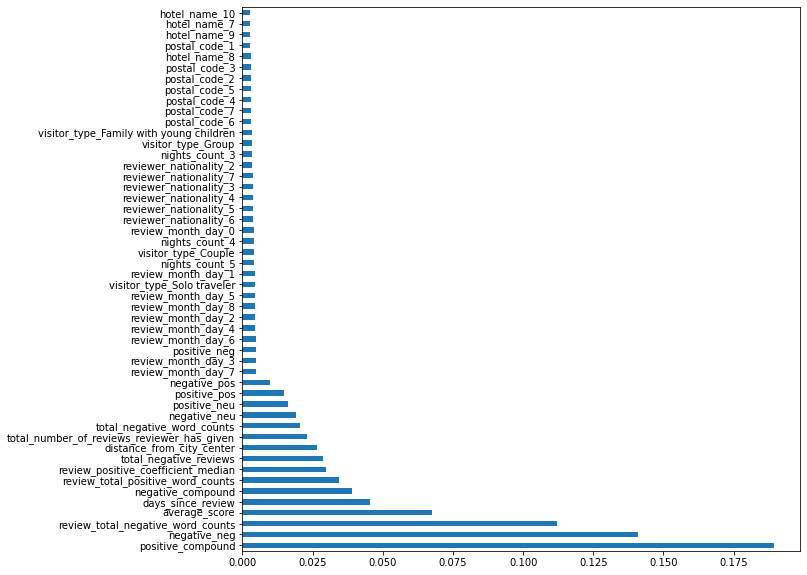

In [223]:
# в RandomForestRegressor есть возможность вывести 
# самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

## 12.2. Обучение модели на всех данных и получение предсказания <a id="item_12_2"></a>

Теперь обучим модель на всех данных, которые у нас есть.

In [224]:
# Снова разделим датафрейм
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
data_hotels_train = get_train_data(data_hotels)

X_train = data_hotels_train.drop(['reviewer_score'], axis=1)  
y_train = data_hotels_train['reviewer_score'] 

In [225]:
# Создаём модель
model_result = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED
)
    
# Обучаем модель 
model_result.fit(X_train, y_train) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [226]:
X_test = get_test_data(data_hotels)

y_pred = model_result.predict(X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    2.1s finished


In [227]:
# в образец сабмишина в столбец reviewer_score поставим свои предсказанные значения
sample_submission['reviewer_score'] = y_pred
# сформируем csv файл
sample_submission.to_csv(DATA_DIR+'submission_result.csv', index=False)
# посмотрим, что у нас получилось
sample_submission.head(10)

,reviewer_score,id
0,8.577,488440
1,7.280,274649
2,9.110,374688
3,9.686,404352
4,9.508,451596
5,8.627,302161
6,7.166,317079
7,7.760,13963
8,8.670,159785
9,7.772,195089
